In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from doctest import master
import datetime
import random
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read datasets

adopterhistory = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_AdopterHistory.csv')
adopterhistory['buy'] = 1

app_data = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_AppData.csv')

feat_data = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_FeatData.csv')

firmographic_data = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_FirmographicData.csv')

install_counts = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_installCounts.csv')

protocol_data = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_ProtocolData.csv')

virt_data = pd.read_csv('Data/UT_MSBA_FirstAdopterAnalysis_VirtData.csv')

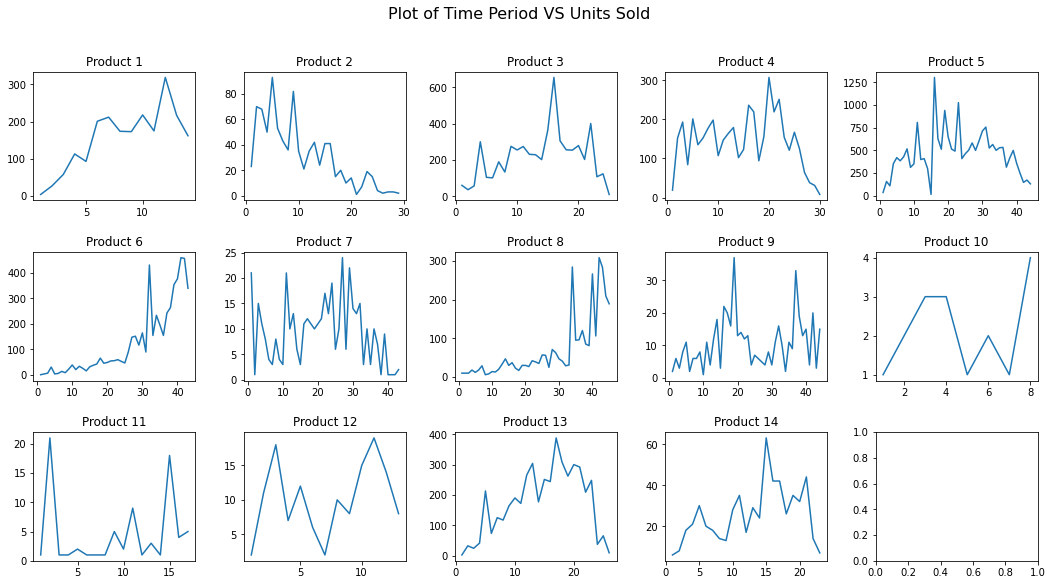

In [3]:
adopterhistory_purchasequant = adopterhistory.groupby(['ProductMasked','ProductTier','ProductFamily','YearMonth']).agg({'PurchaseQuantity':'sum'}).reset_index()
adopterhistory_purchasequant['row_number']=adopterhistory_purchasequant.groupby(['ProductMasked'])['YearMonth'].cumcount()+1
adopterhistory_purchasequant.drop(columns='YearMonth',inplace=True)

fig, axs = plt.subplots(3,5, figsize=(18, 9))
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()

for i in range(14):
    df_tmp = adopterhistory_purchasequant[adopterhistory_purchasequant['ProductMasked']==i+1]
    axs[i].plot(df_tmp['row_number'],df_tmp['PurchaseQuantity'])
    axs[i].set_title('Product '+str(i+1))

fig.suptitle('Plot of Time Period VS Units Sold', fontsize=16)
plt.draw()

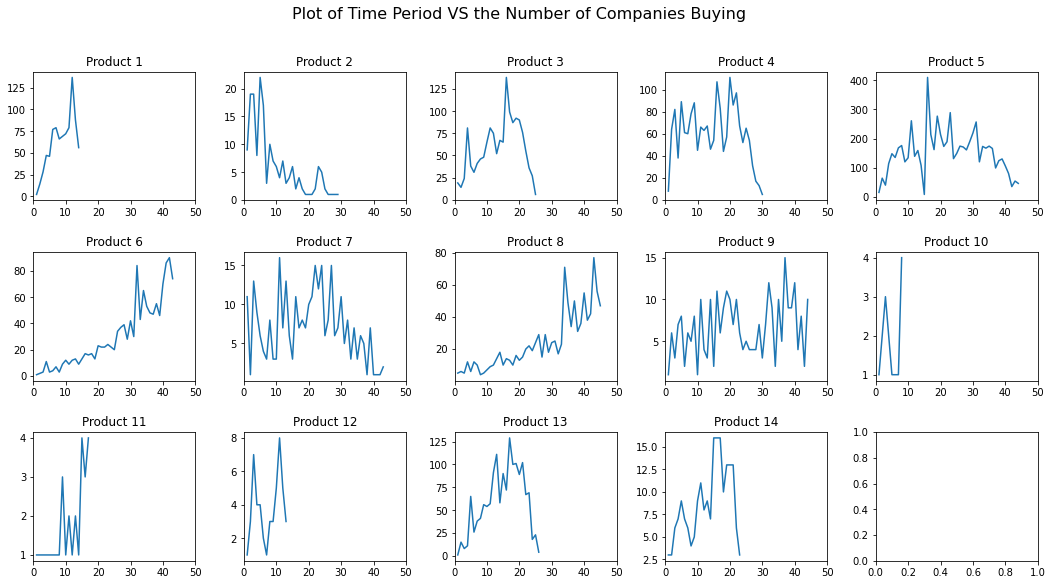

In [4]:
adopterhistory_companyquant = adopterhistory.groupby(['ProductMasked','ProductTier','ProductFamily','YearMonth']).agg({'buy':'sum'}).reset_index()
adopterhistory_companyquant['row_number']=adopterhistory_companyquant.groupby(['ProductMasked'])['YearMonth'].cumcount()+1
# adopterhistory_companyquant.drop(columns='YearMonth',inplace=True)

fig, axs = plt.subplots(3,5, figsize=(18, 9))
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()

for i in range(14):
    df_tmp = adopterhistory_companyquant[adopterhistory_companyquant['ProductMasked']==i+1]
    axs[i].plot(df_tmp['row_number'],df_tmp['buy'])
    axs[i].set_xlim(0,50)
    axs[i].set_title('Product '+str(i+1))

fig.suptitle('Plot of Time Period VS the Number of Companies Buying', fontsize=16)
plt.draw()

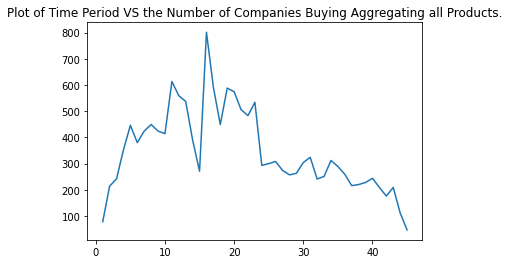

In [5]:
plt.title('Plot of Time Period VS the Number of Companies Buying Aggregating all Products.')
plt.plot(adopterhistory_companyquant[['buy','row_number']].groupby('row_number').sum())

In [5]:
# how many months has the product launched?

launch_duration = adopterhistory_companyquant[['ProductMasked','row_number']].groupby('ProductMasked').max()['row_number']

In [6]:
# decide the threshold for products with different lifetime

cumsum = adopterhistory_companyquant[['buy','row_number']].groupby('row_number').mean()['buy'].cumsum()
dic_threshold = {}
for i in range(12,46):
    dic_threshold[i] = cumsum[11]/cumsum[i]

In [7]:
# put all 14 products into 3 groups, the splitting criterion shows below 

adopterhistory_companyquant['adopter'] = 0
total_buy = []
for i in range(1,15):
    total_buy.append(sum(adopterhistory_companyquant[adopterhistory_companyquant['ProductMasked']==i]['buy']))
spike = [2,7,12]
spike_cuttime = [4, 7, 5]
normal = [1,3,4,5,6,8,9,11,13,14]

#### if the product is launched less than a year ago,
     include all the company as early adopters (example: product 10)

In [8]:
adopterhistory_companyquant.loc[adopterhistory_companyquant['ProductMasked']==10, ['adopter']] = 1

#### else,
     use the threshold dictionary

##### if there is a **clear spike** at the beginning of the curve,
      we can set the companies in the spike as early adopters; if the companies in the spike doesn't count as x% of the total number, we include more to reach x%.  (example: product 2, 7, 12)

In [9]:
for i, j in zip(spike, spike_cuttime):
    sum_tmp = sum(adopterhistory_companyquant[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']<=j)]['buy'])
    adopterhistory_companyquant.loc[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']<=j),['adopter']] = 1
    while sum_tmp < dic_threshold[launch_duration[i]]*total_buy[i-1]:
        adopterhistory_companyquant.loc[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']==j), ['adopter']] = 1
        sum_tmp += adopterhistory_companyquant[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']==j+1)]['buy'].values[0]
        j += 1

##### if the curve looks normal or skewed normal,
      we set the first x% companies as the early adopters. (example: product 1, 3, 4)

In [10]:
# for normal products
for i in normal:
    row_number = 1
    sum_tmp = 0
    while sum_tmp < dic_threshold[launch_duration[i]]*total_buy[i-1]:
        adopterhistory_companyquant.loc[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']==row_number), ['adopter']] = 1
        sum_tmp += adopterhistory_companyquant[(adopterhistory_companyquant['ProductMasked']==i) & (adopterhistory_companyquant['row_number']==row_number)]['buy'].values[0]
        row_number += 1

In [11]:
# cutoff time for each product

cutoff_series = adopterhistory_companyquant[adopterhistory_companyquant['adopter']==1][['ProductMasked','row_number']].groupby('ProductMasked').max()['row_number']

X-axis: time window; Y-axis: cnt of companies who bought in time x


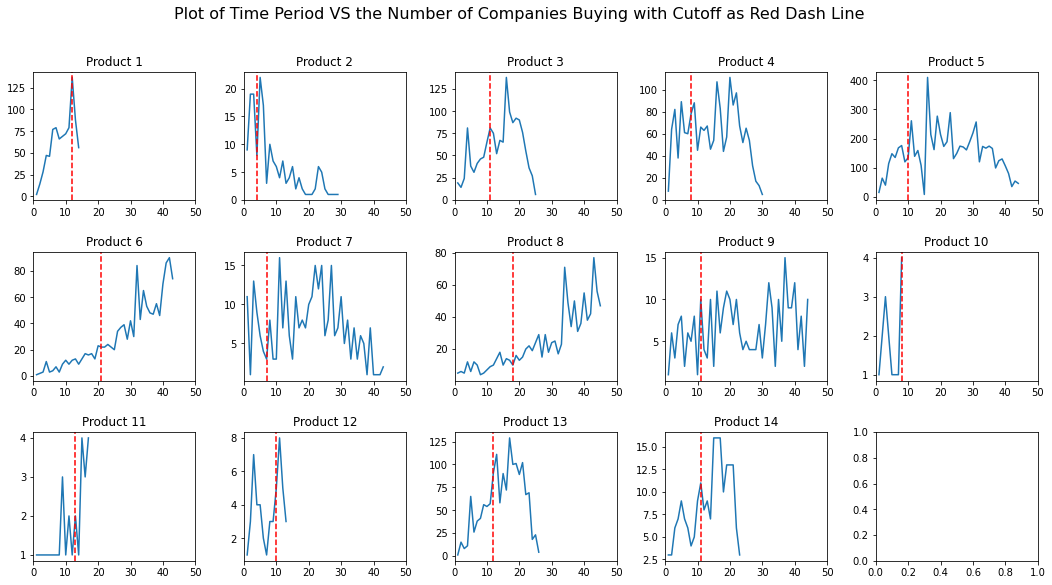

In [12]:
fig, axs = plt.subplots(3,5, figsize=(18, 9))
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()
print('X-axis: time window; Y-axis: cnt of companies who bought in time x')

for i in range(14):
    df_tmp = adopterhistory_companyquant[adopterhistory_companyquant['ProductMasked']==i+1]
    axs[i].plot(df_tmp['row_number'],df_tmp['buy'])
    axs[i].axvline(cutoff_series[i+1],color='red',linestyle='--')
    axs[i].set_xlim(0,50)
    axs[i].set_title('Product '+str(i+1))

fig.suptitle('Plot of Time Period VS the Number of Companies Buying with Cutoff as Red Dash Line', fontsize=16)
plt.draw()

In [13]:
# company level score of being an early adopter

early_adopter = adopterhistory_companyquant[['ProductMasked','YearMonth','adopter']]
labeled = adopterhistory.merge(early_adopter,on=['ProductMasked','YearMonth'])
percentage_adopting = labeled[['CompanyID','adopter']].groupby('CompanyID').mean().reset_index()
percentage_adopting = percentage_adopting[percentage_adopting['CompanyID']!=-999999]
ea = (np.array(percentage_adopting['adopter'].values)>0.4)
percentage_adopting['early_adopter'] = ea
percentage_adopting

,CompanyID,adopter,early_adopter
1,11556058,0.000000,False
2,11556197,0.000000,False
3,11556328,0.000000,False
4,11556544,0.000000,False
5,11556551,0.230769,False
...,...,...,...
7722,21887460,0.000000,False
7723,21888651,0.000000,False
7724,21888673,0.000000,False
7725,21888681,0.000000,False


In [16]:
percentage_adopting.to_csv('final_target_file.csv')

In [17]:
# Checking Duplicates at CompanyID and YearMonth level before merging all of them

print(len(adopterhistory),len(adopterhistory[['CompanyID','YearMonth','ProductMasked']].drop_duplicates()))
print(len(app_data),len(app_data[['CompanyId','YearMonth']].drop_duplicates()))
print(len(feat_data),len(feat_data[['CompanyId','YearMonth']].drop_duplicates()))
print(len(firmographic_data))
print(len(install_counts),len(install_counts[['CompanyId','YearMonth']].drop_duplicates()))
print(len(protocol_data),len(protocol_data[['CompanyId','YearMonth']].drop_duplicates()))
print(len(virt_data),len(virt_data[['CompanyId','YearMonth']].drop_duplicates()))

15655 15655
267117 267117
267303 267303
4829
267259 267259
267260 267260
267259 267259


In [18]:
# merged datasets (minus adopter history and firmographic)

master_data = pd.DataFrame()
filenames = [app_data,feat_data,protocol_data,virt_data,install_counts]
master_data = pd.merge(app_data, feat_data, on =['CompanyId','YearMonth'])
master_data = pd.merge(master_data, protocol_data, on =['CompanyId','YearMonth'])
master_data = pd.merge(master_data, virt_data, on =['CompanyId','YearMonth'])
master_data = pd.merge(master_data, install_counts, on =['CompanyId','YearMonth'])

In [20]:
# check NaN values

master_data.isna().sum()

CompanyId                          0
YearMonth                          0
USAGE_APP1_SYSCOUNT                0
USAGE_APP2_SYSCOUNT                0
USAGE_APP3_SYSCOUNT                0
USAGE_APP4_SYSCOUNT                0
USAGE_APP5_SYSCOUNT                0
USAGE_APP6_SYSCOUNT                0
USAGE_APP7_SYSCOUNT                0
USAGE_APP8_SYSCOUNT                0
USAGE_APP9_SYSCOUNT                0
USAGE_APP10_SYSCOUNT               0
USAGE_APP11_SYSCOUNT               0
USAGE_FEAT1_SYSCOUNT               0
USAGE_FEAT2_SYSCOUNT               0
USAGE_FEAT3_SYSCOUNT               0
USAGE_FEAT4_SYSCOUNT               0
USAGE_FEAT5_SYSCOUNT               0
USAGE_FEAT6_SYSCOUNT               0
USAGE_FEAT7_SYSCOUNT               0
USAGE_FEAT8_SYSCOUNT               0
USAGE_FEAT9_SYSCOUNT               0
USAGE_FEAT10_SYSCOUNT              0
USAGE_FEAT11_SYSCOUNT              0
USAGE_FEAT12_SYSCOUNT              0
USAGE_FEAT13_SYSCOUNT              0
USAGE_PROTOCOL1_SYSCOUNT           0
U

In [21]:
# check distribution of each columns

master_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,CompanyId,YearMonth,USAGE_APP1_SYSCOUNT,USAGE_APP2_SYSCOUNT,USAGE_APP3_SYSCOUNT,USAGE_APP4_SYSCOUNT,USAGE_APP5_SYSCOUNT,USAGE_APP6_SYSCOUNT,USAGE_APP7_SYSCOUNT,USAGE_APP8_SYSCOUNT,USAGE_APP9_SYSCOUNT,USAGE_APP10_SYSCOUNT,USAGE_APP11_SYSCOUNT,USAGE_FEAT1_SYSCOUNT,USAGE_FEAT2_SYSCOUNT,USAGE_FEAT3_SYSCOUNT,USAGE_FEAT4_SYSCOUNT,USAGE_FEAT5_SYSCOUNT,USAGE_FEAT6_SYSCOUNT,USAGE_FEAT7_SYSCOUNT,USAGE_FEAT8_SYSCOUNT,USAGE_FEAT9_SYSCOUNT,USAGE_FEAT10_SYSCOUNT,USAGE_FEAT11_SYSCOUNT,USAGE_FEAT12_SYSCOUNT,USAGE_FEAT13_SYSCOUNT,USAGE_PROTOCOL1_SYSCOUNT,USAGE_PROTOCOL2_SYSCOUNT,USAGE_PROTOCOL3_SYSCOUNT,USAGE_PROTOCOL4_SYSCOUNT,USAGE_PROTOCOL5_SYSCOUNT,USAGE_PROTOCOL6_SYSCOUNT,USAGE_PROTOCOL7_SYSCOUNT,USAGE_PROTOCOL8_SYSCOUNT,USAGE_PROTOCOL9_SYSCOUNT,USAGE_VIRT1_SYSCOUNT,USAGE_VIRT2_SYSCOUNT,USAGE_VIRT3_SYSCOUNT,AllSystems_Count,ProductFamily_A_count,ProductFamily_B_count,ProductFamily_C_count,ProductFamily_D_count,ProductFamily_E_count,ProductFamily_A_Entry_count,ProductFamily_A_Mid_count,ProductFamily_A_High_count,ProductFamily_C_Entry_count,ProductFamily_C_Mid_count,ProductFamily_C_High_count,ProductFamily_D_Category1_count,ProductFamily_D_Category2_count,ProductFamily_D_Provider1_count,ProductFamily_D_Provider2_count,ProductFamily_D_Provider3_count
count,2.670730e+05,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.0,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000,267073.000000
mean,1.428107e+07,201979.446773,3.631269,1.403279,3.880733,0.438318,1.618337,2.302311,0.416055,0.071999,0.048223,0.005815,0.524475,14.251684,2.158668,16.775833,21.859615,18.837067,1.022432,0.042775,2.650455,0.330176,0.0,8.104990,9.629641,0.506918,21.626514,8.529630,12.062496,0.377099,4.571125,4.655195,20.292512,7.749027,8.541361,1.179775,0.707645,10.937238,23.361047,5.525864,0.000049,17.072961,0.272839,0.153973,1.704635,1.755059,2.066169,8.067274,6.583837,2.421851,0.138367,0.126580,0.136850,0.073856,0.000629
std,3.715095e+06,106.063030,10.259109,3.807538,9.567441,2.495429,7.769838,13.249878,6.125315,0.688385,0.509657,0.147620,2.881708,44.256310,6.323528,47.763902,68.553197,57.099547,4.280235,0.462973,10.333538,1.890644,0.0,30.267358,33.904656,2.873563,68.461872,21.397194,32.313773,2.382077,12.639699,15.173905,66.542707,19.693481,21.430599,17.174588,3.184998,24.632864,72.014734,24.248169,0.020202,54.774603,3.348500,2.212283,4.773025,11.371535,15.521330,25.951169,24.404018,18.921297,2.744556,1.574564,2.181034,0.968973,0.031315
min,-9.999990e+05,201805.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.166284e+07,201905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0000

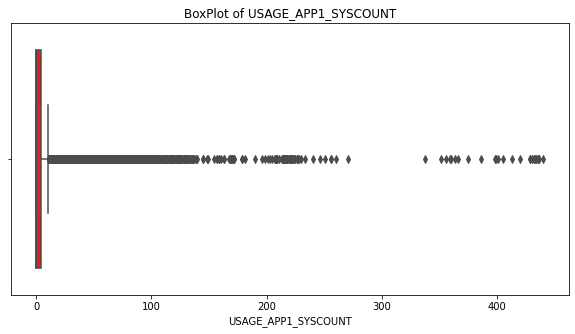

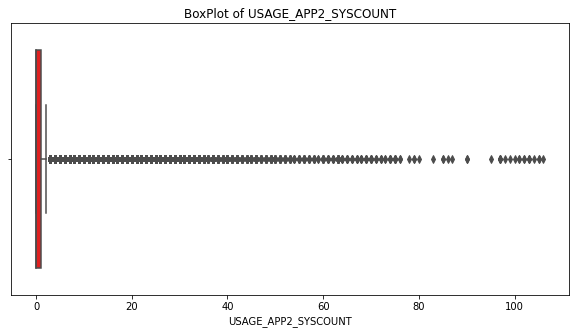

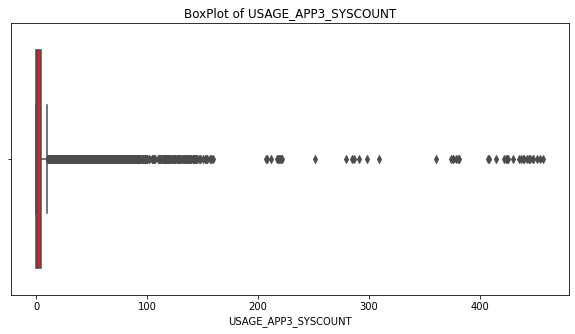

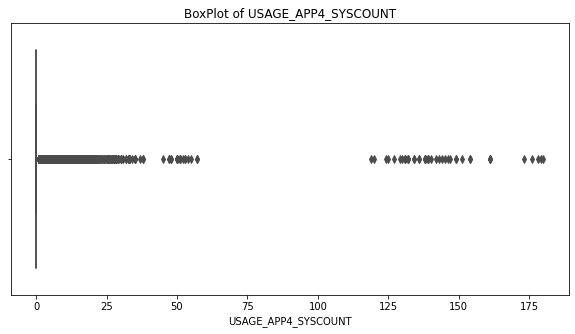

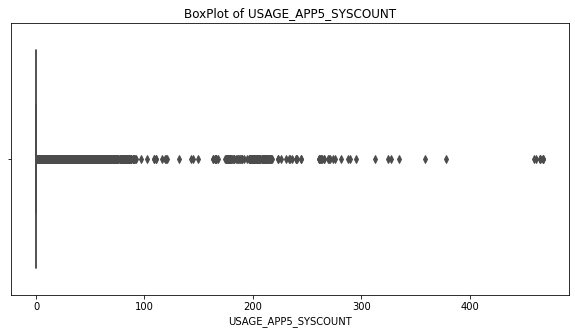

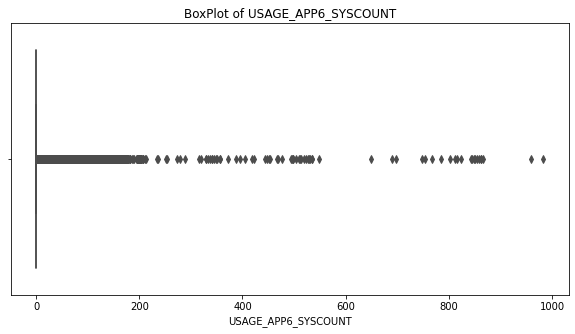

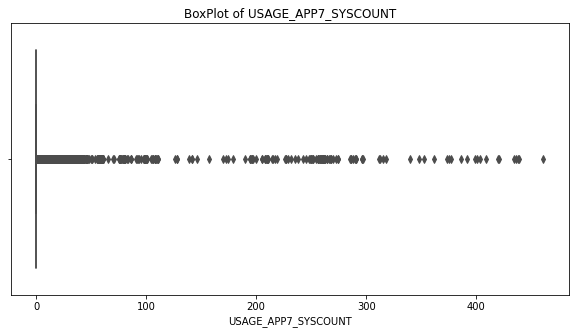

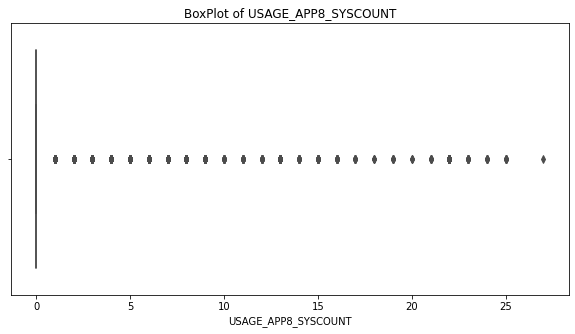

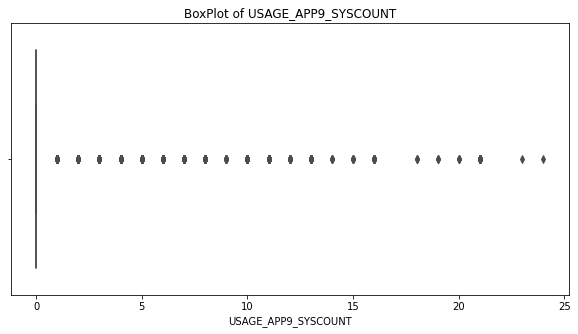

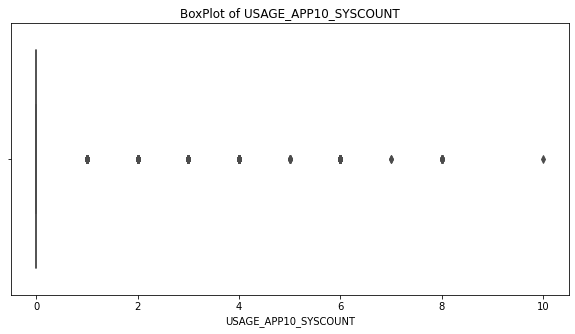

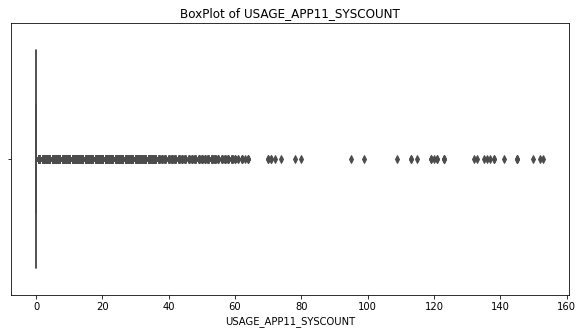

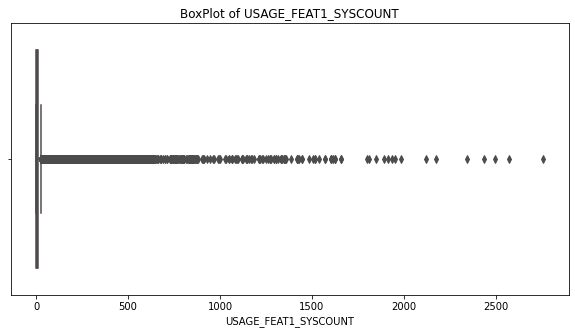

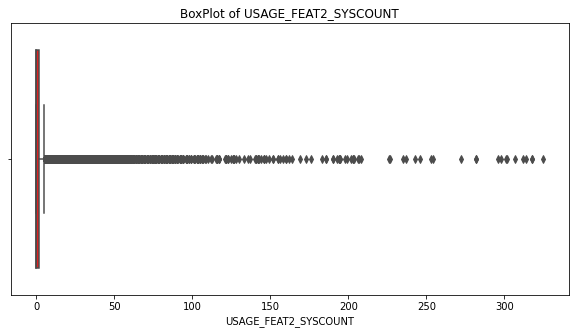

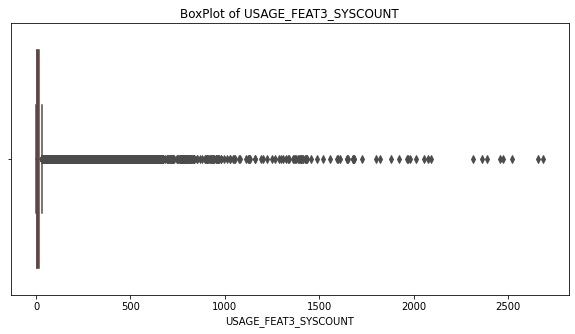

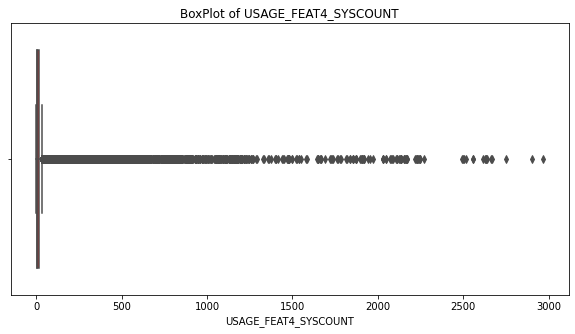

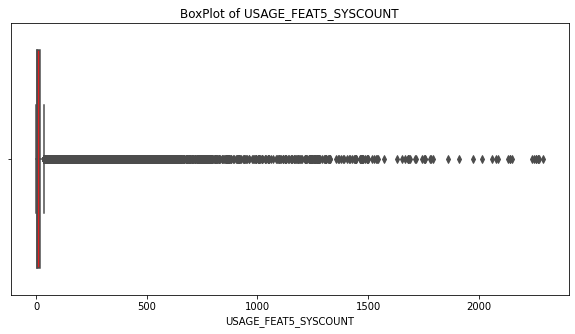

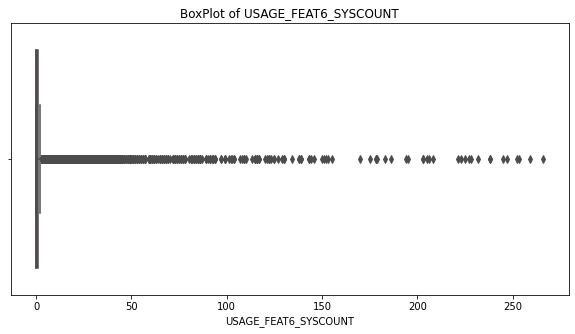

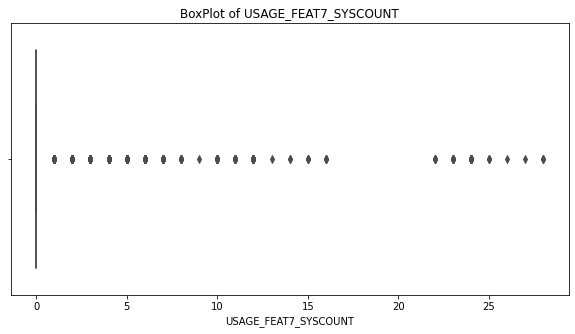

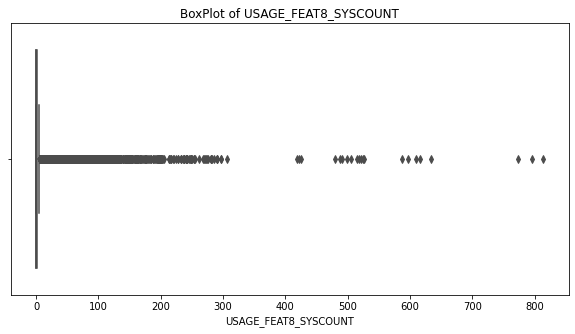

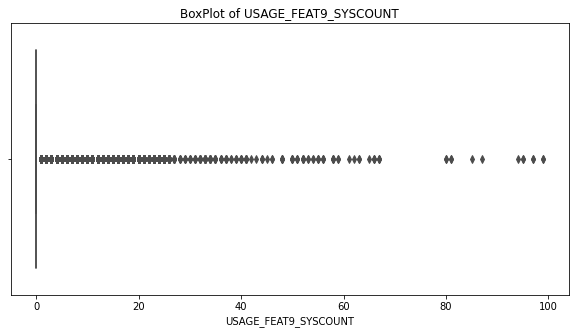

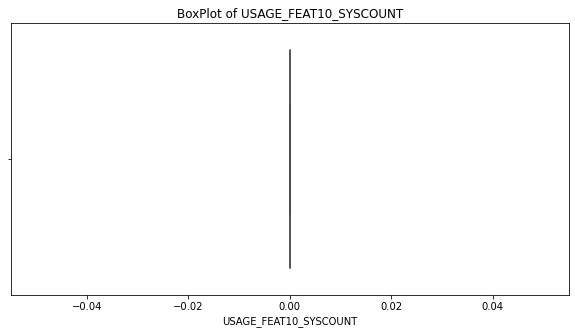

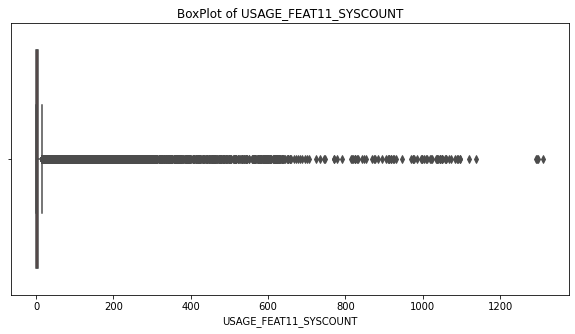

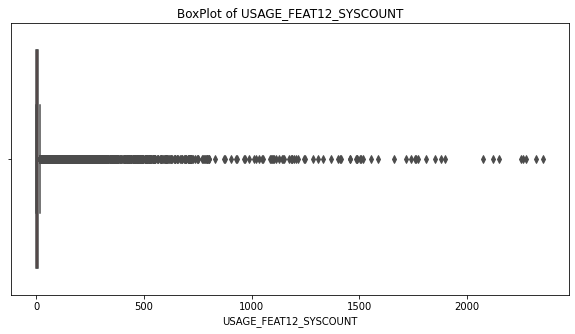

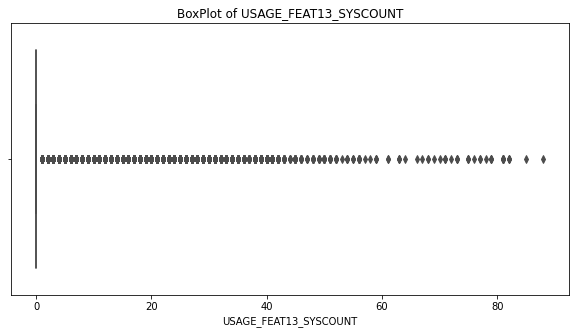

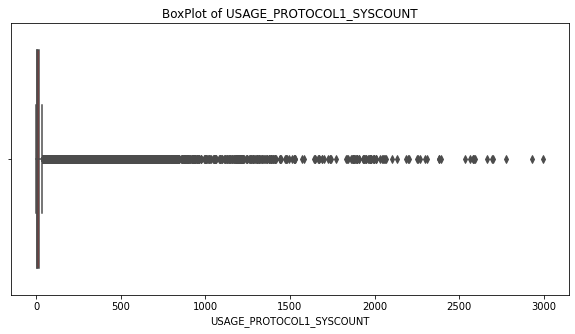

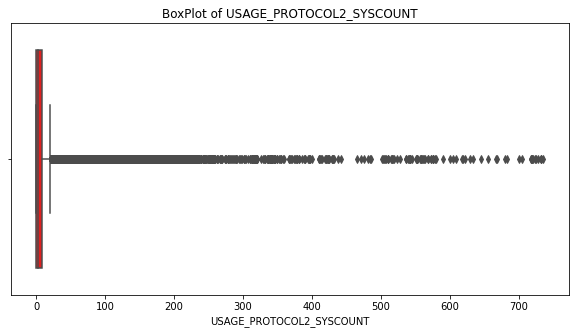

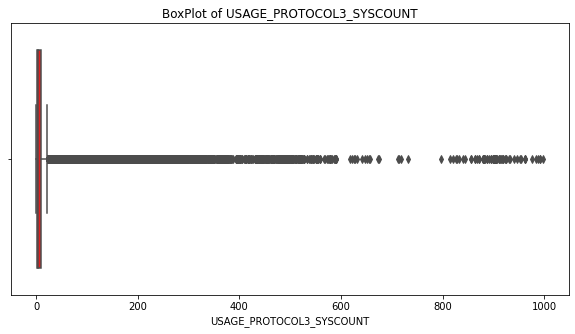

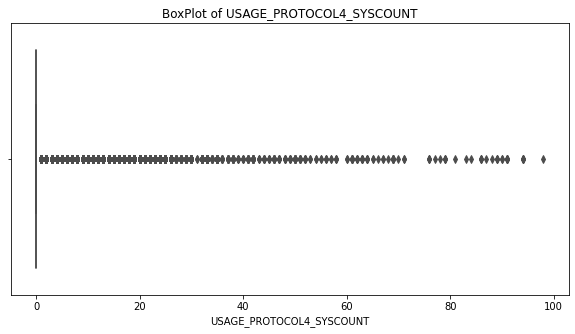

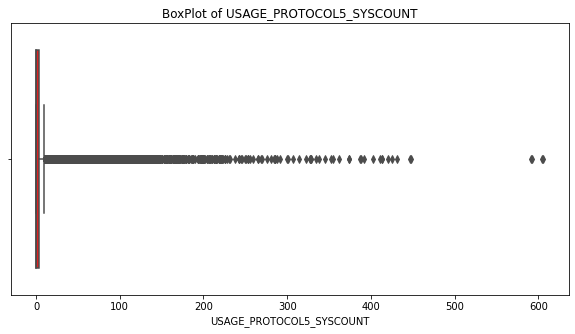

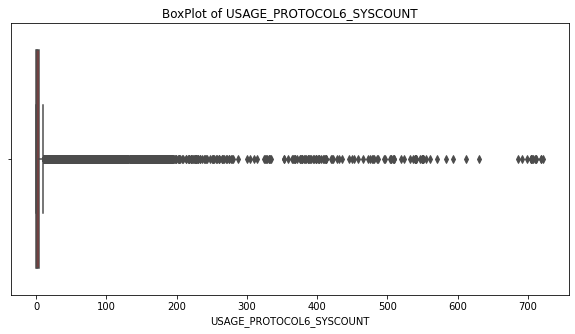

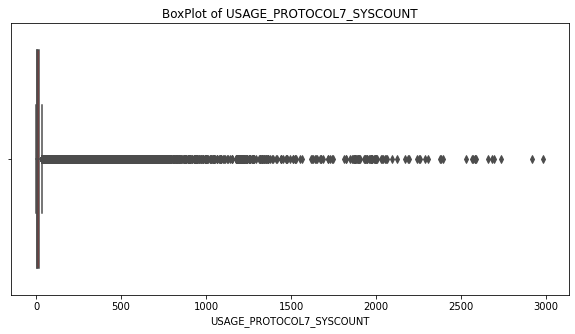

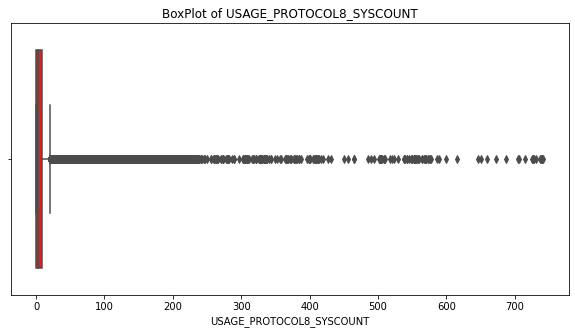

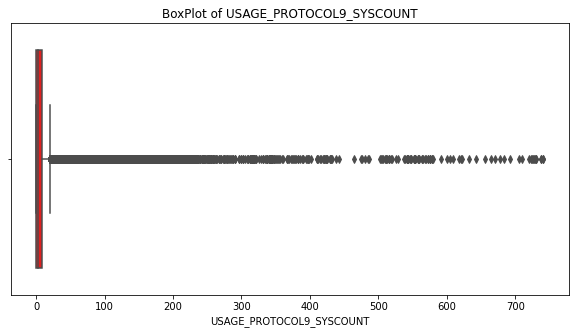

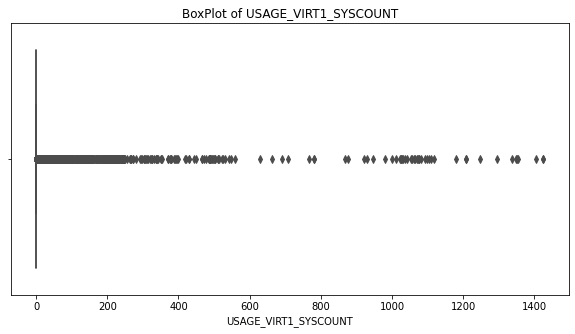

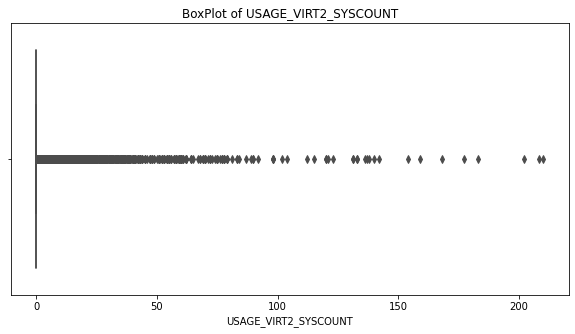

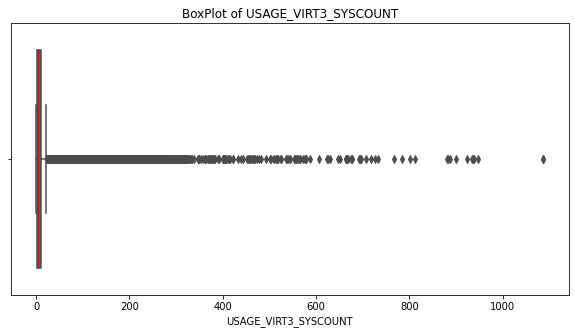

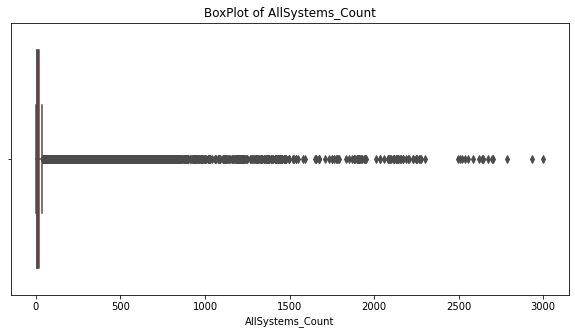

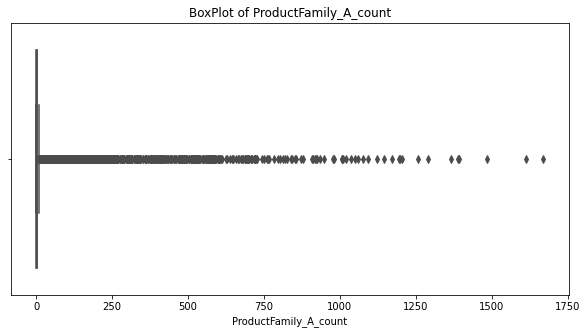

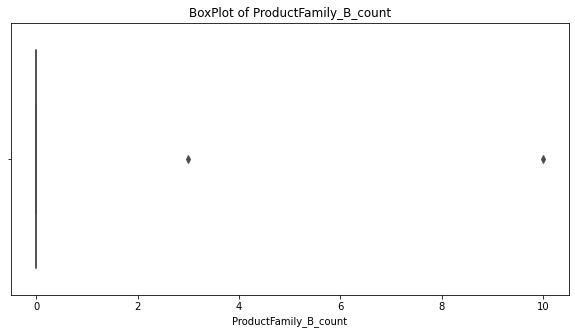

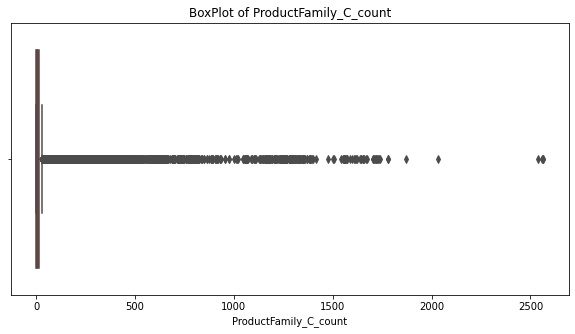

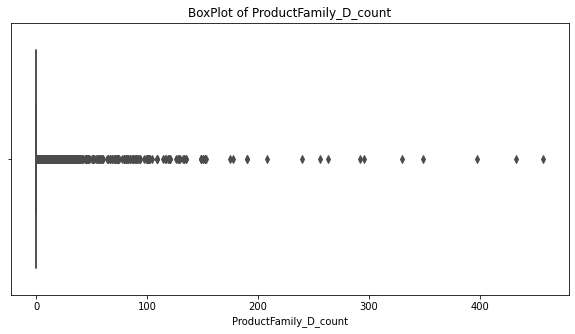

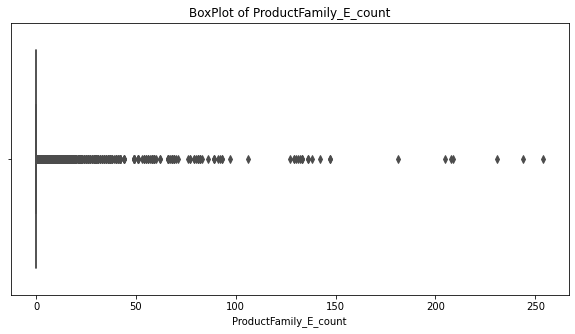

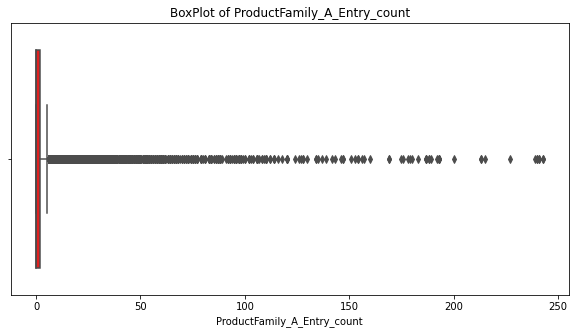

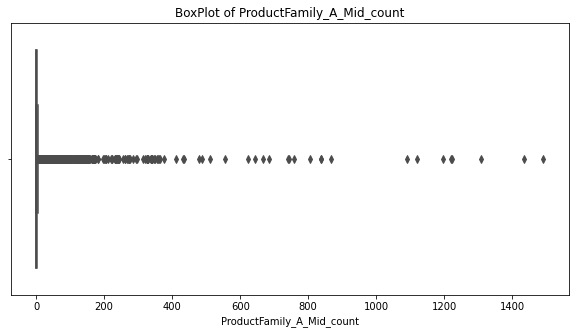

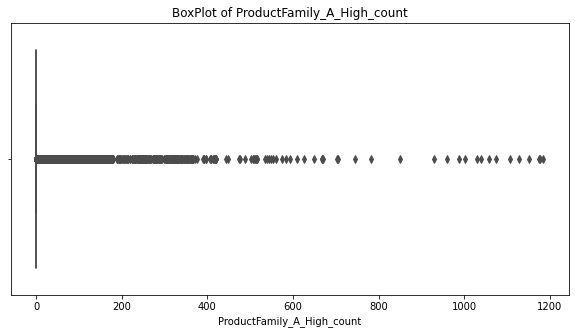

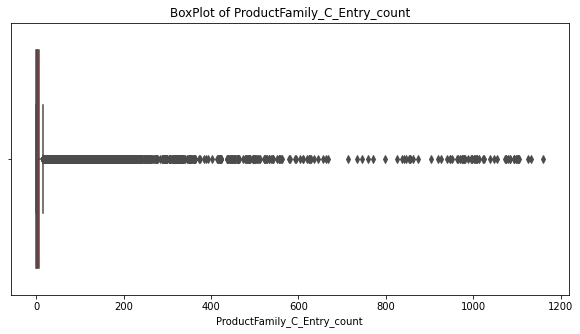

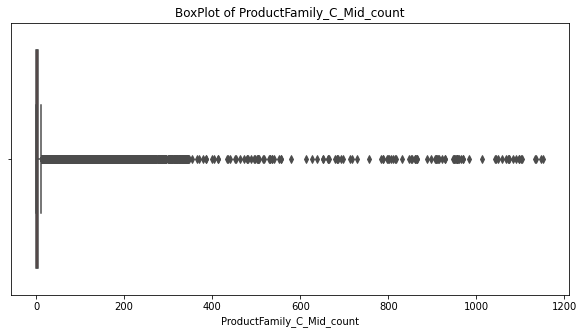

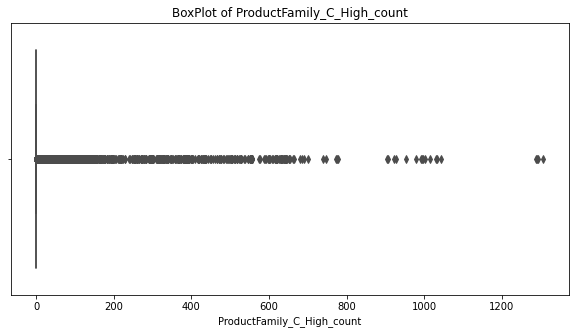

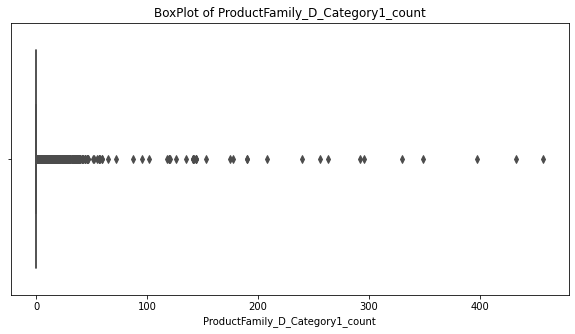

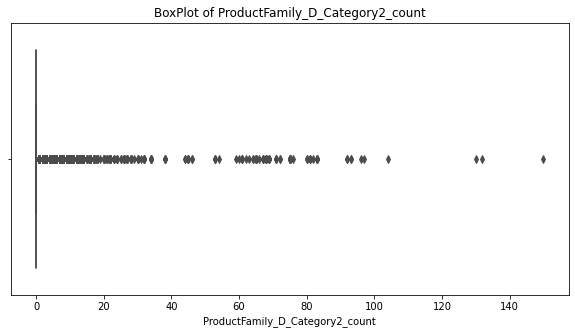

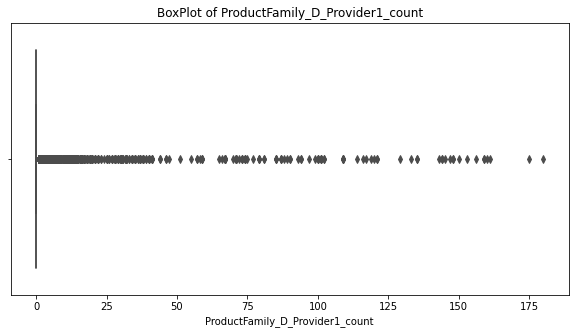

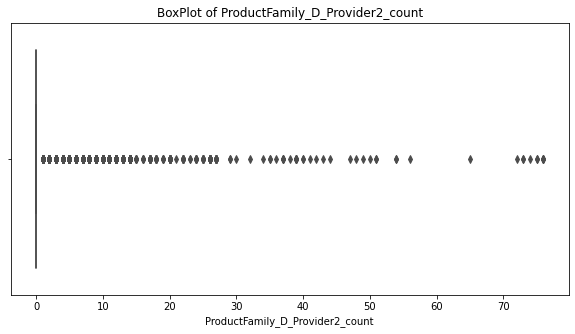

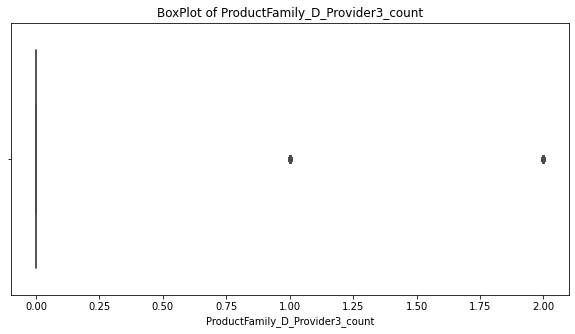

In [23]:
# boxplot for each columns

cols = master_data.columns[2:] 

for col in cols:
    plt.figure(figsize=(10,5))
    sns.boxplot(master_data[col],color='red')
    plt.title('BoxPlot of {}'.format(col))
    plt.show()

## Boxplot of features removing 0

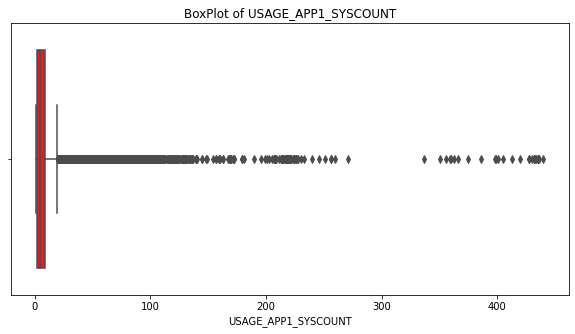

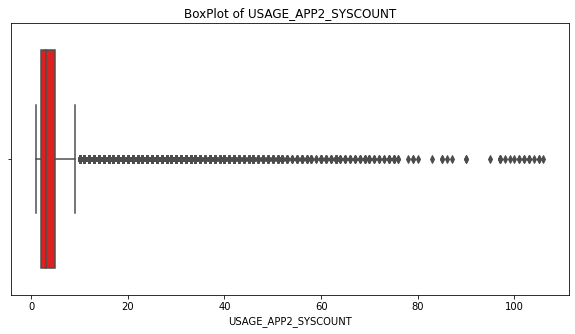

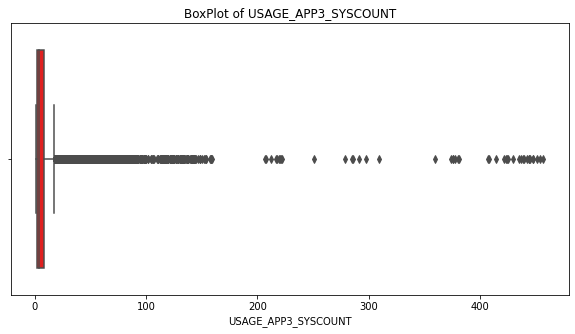

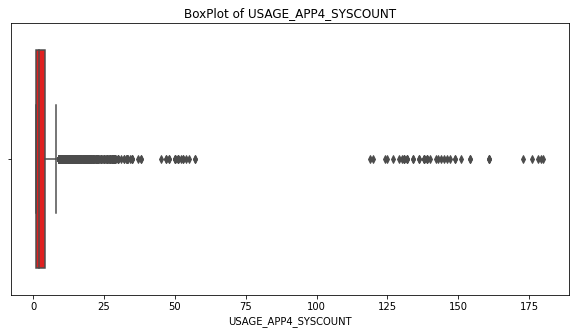

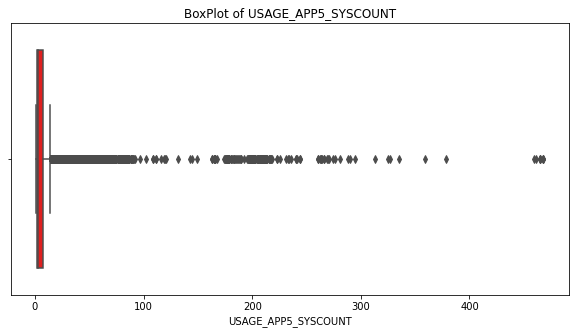

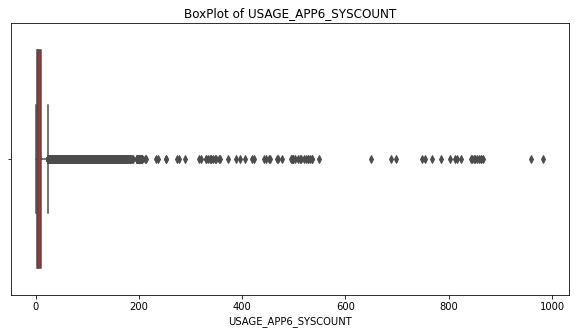

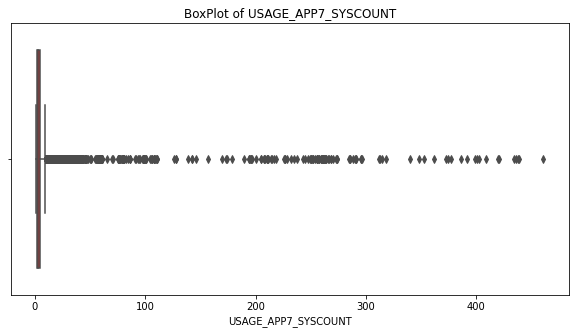

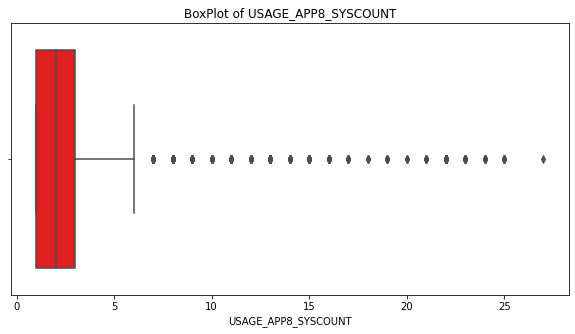

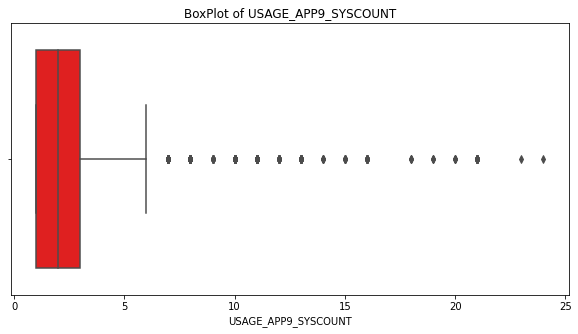

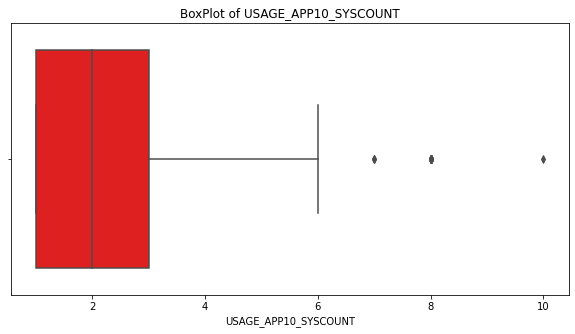

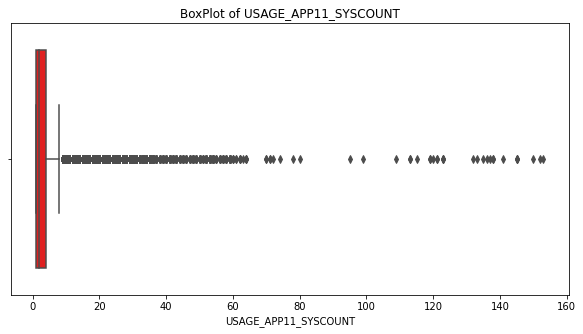

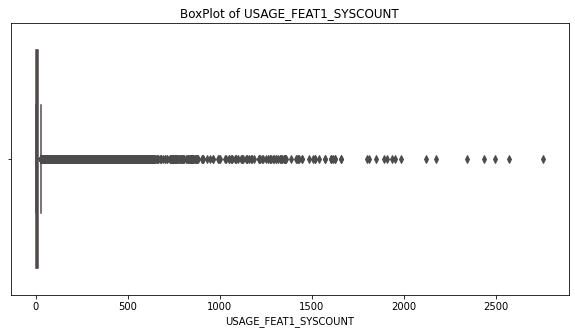

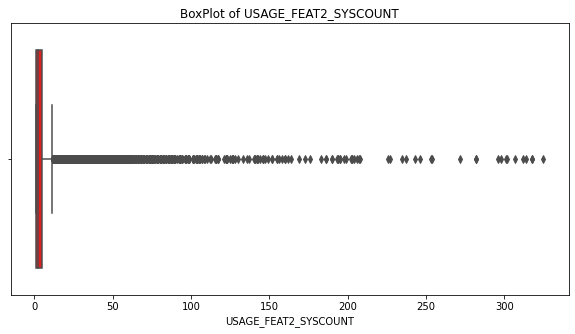

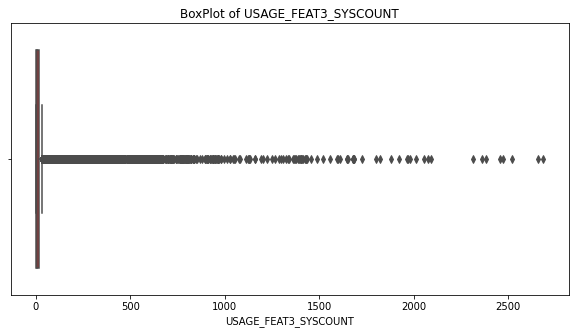

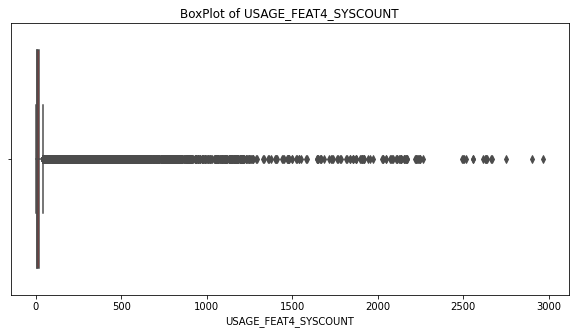

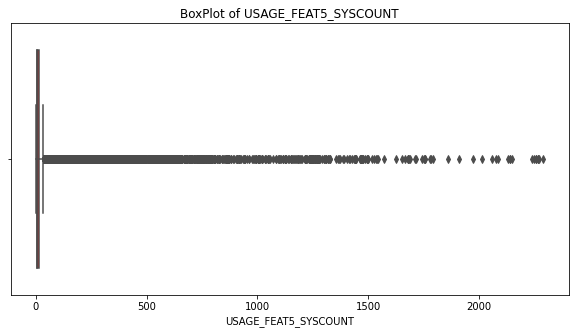

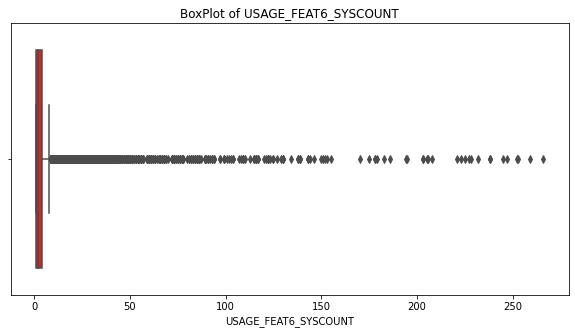

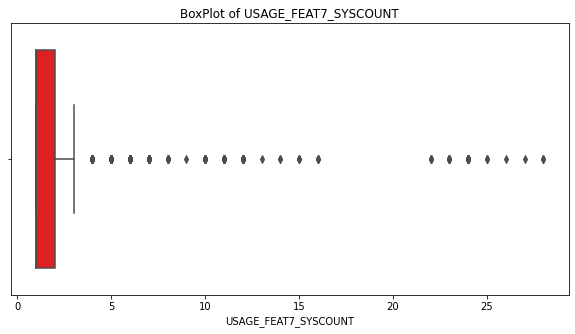

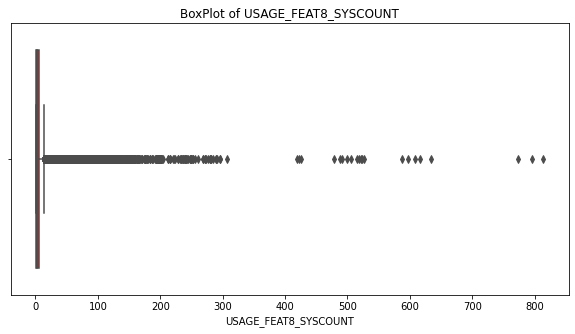

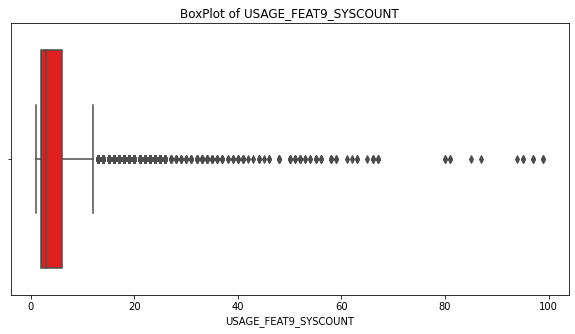

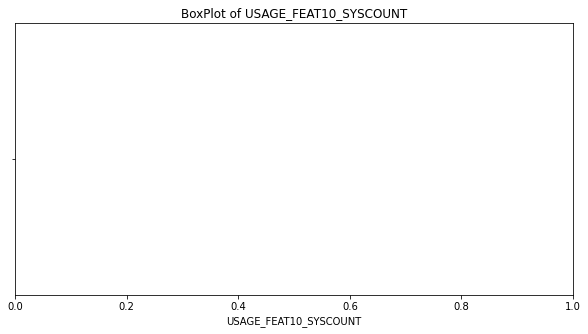

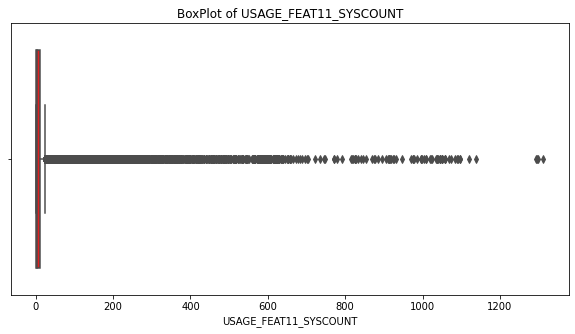

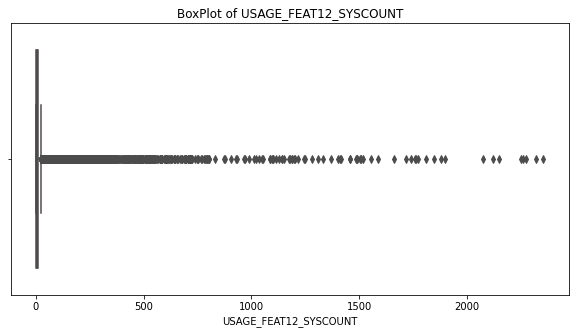

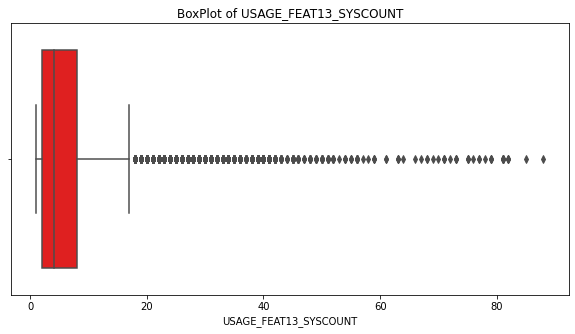

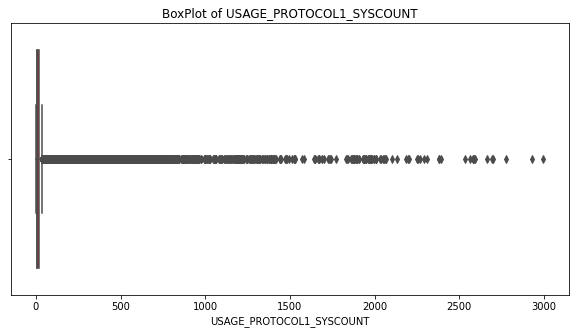

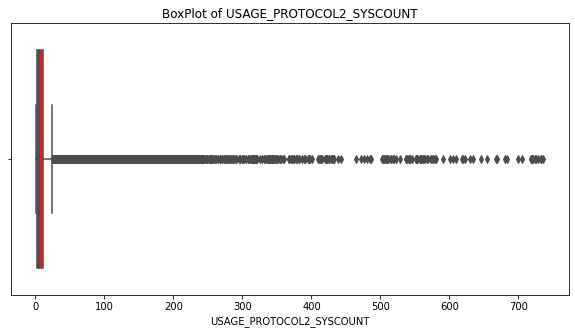

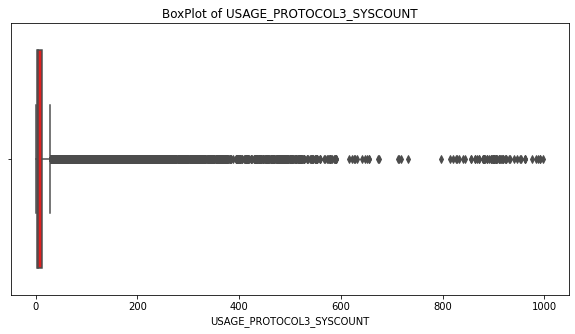

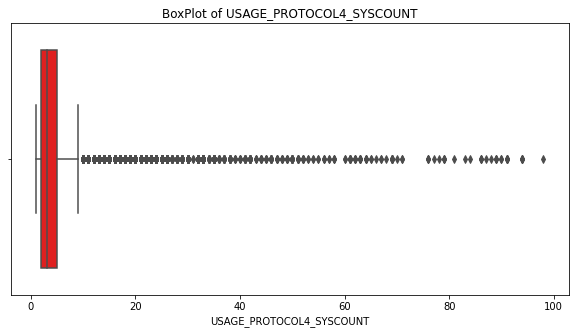

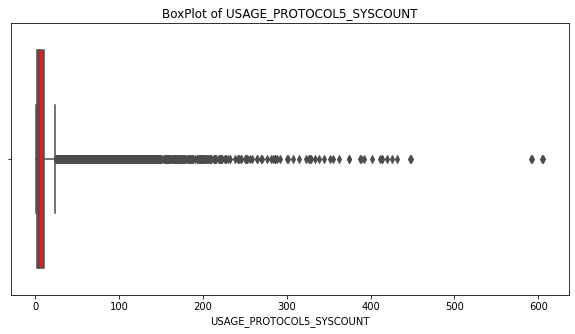

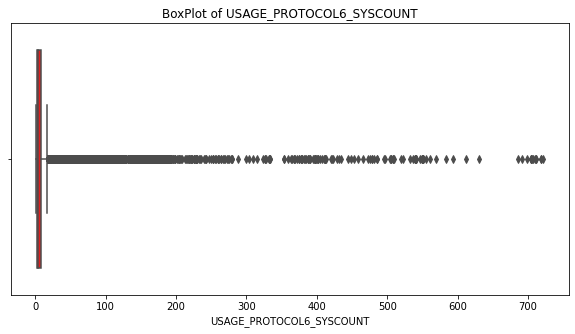

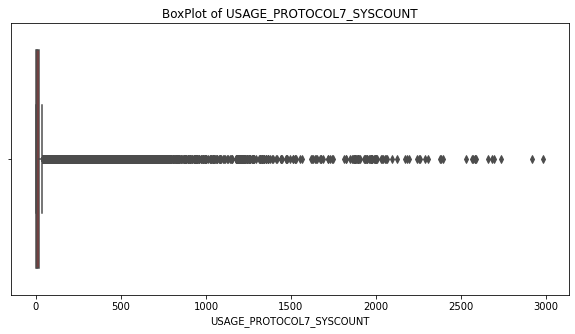

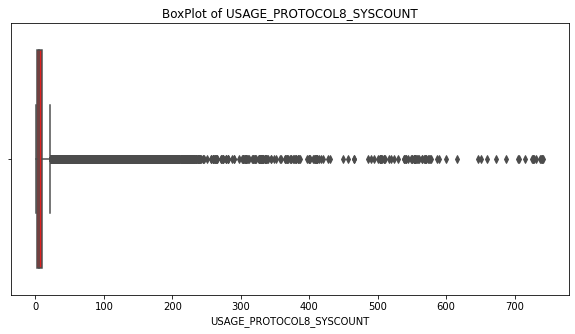

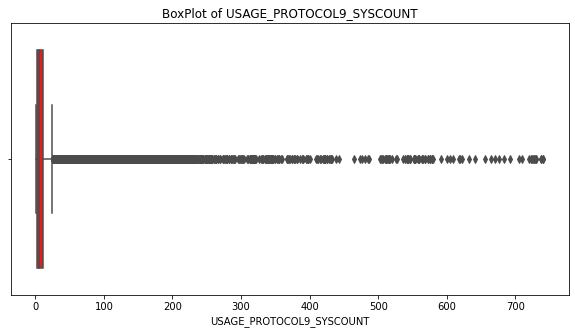

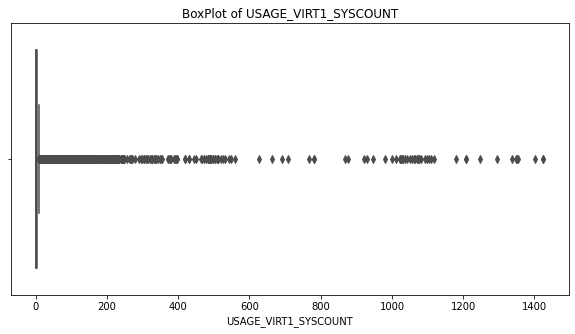

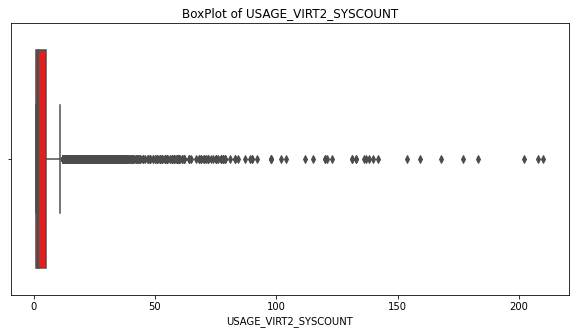

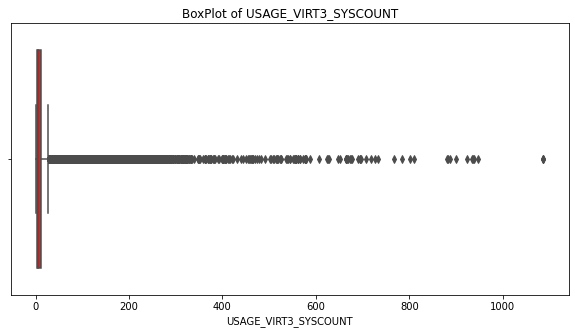

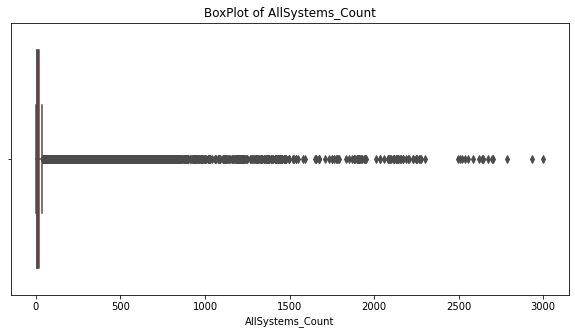

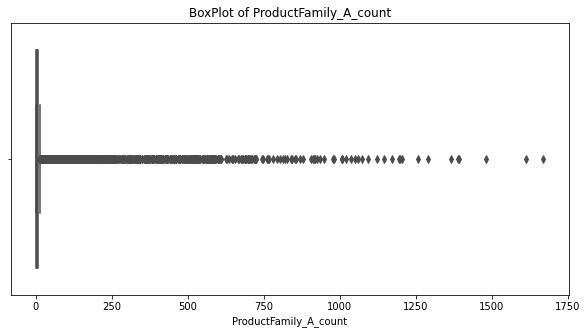

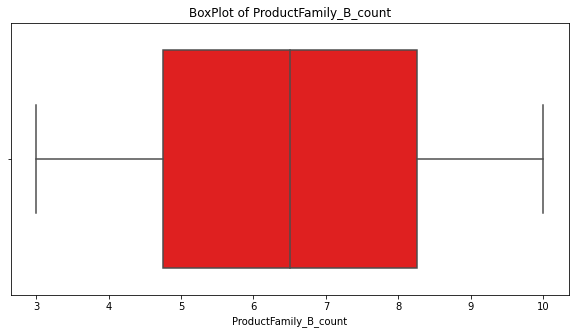

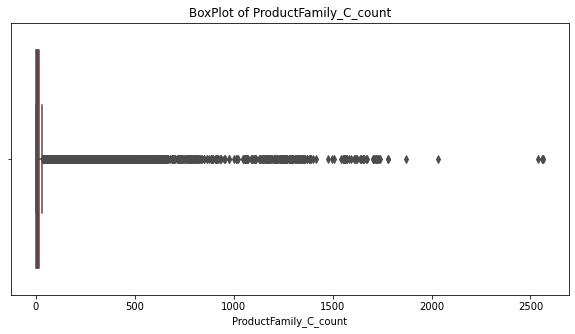

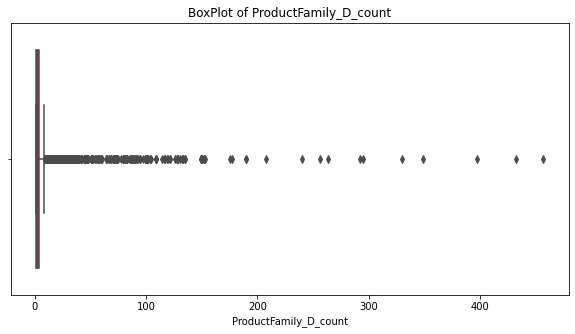

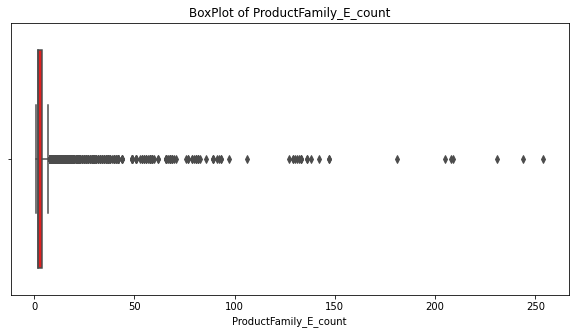

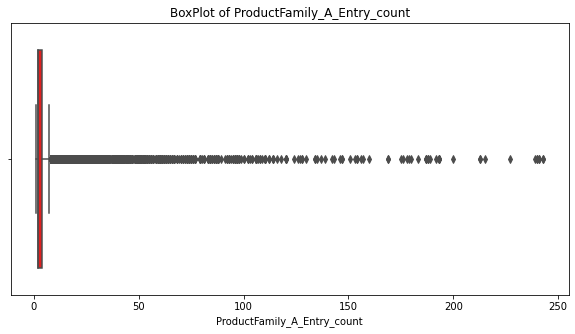

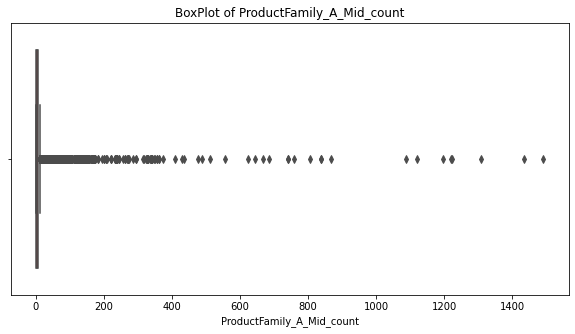

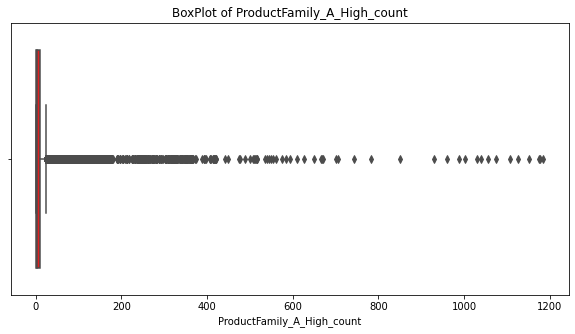

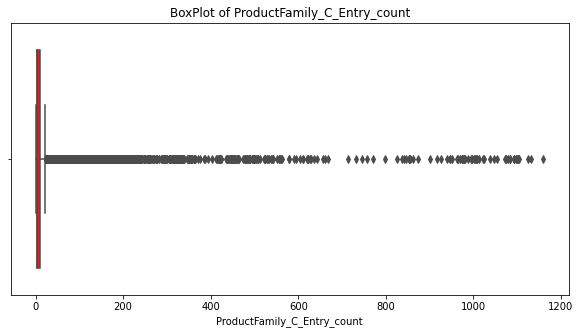

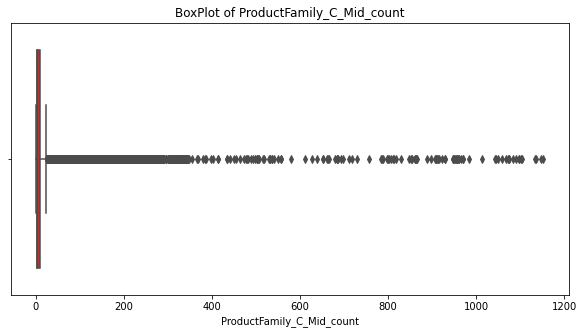

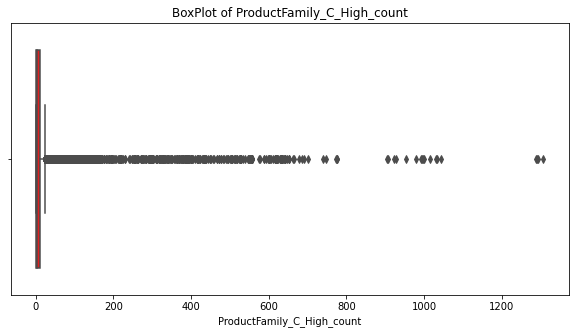

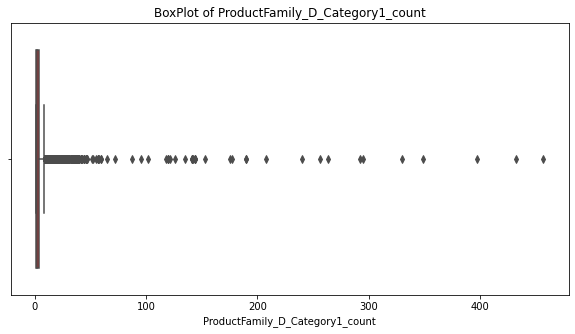

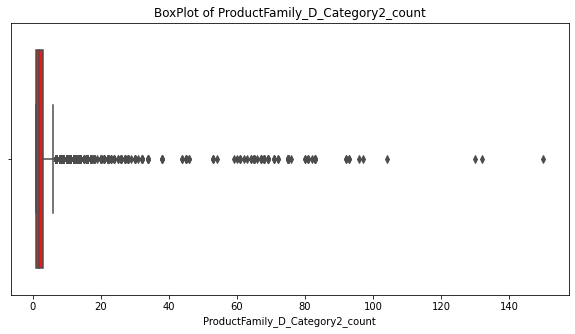

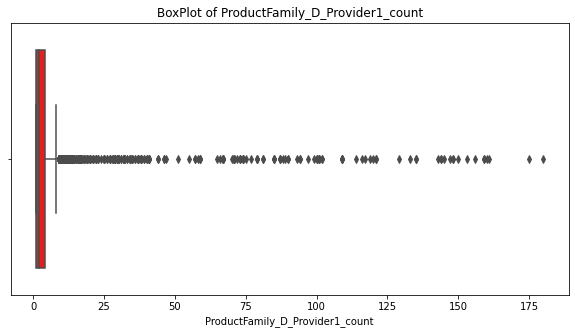

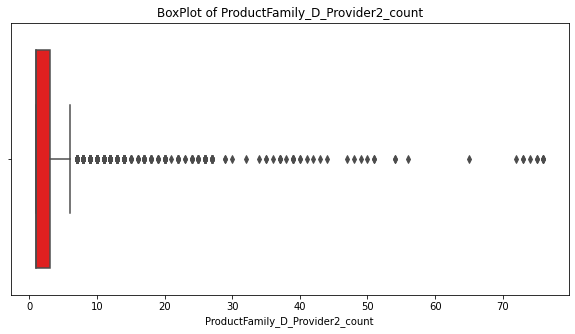

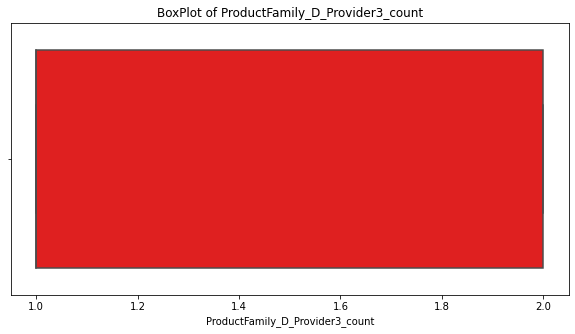

In [25]:
for col in cols:
    plt.figure(figsize=(10,5))
    temp = master_data[master_data[col]>0]
    sns.boxplot(temp[col],color='red')
    plt.title('BoxPlot of {}'.format(col))
    plt.show()

In [39]:
usage_app_cols = app_data.columns[2:]

usage_feat_cols = feat_data.columns[2:]

usage_virt_cols = virt_data.columns[2:]

usage_prtocol_cols = protocol_data.columns[2:]

product_family_cols = install_counts.columns[2:]

all_cols = [usage_app_cols, usage_feat_cols, usage_prtocol_cols, usage_virt_cols, product_family_cols]

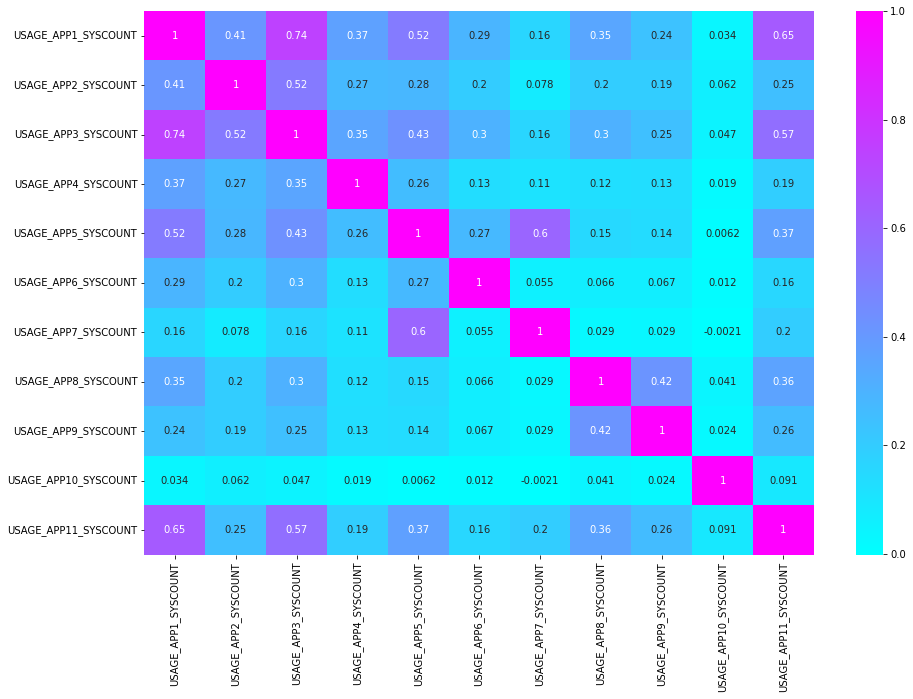

In [41]:
# correlation heat map for app dataset

plt.figure(figsize=(15,10))
sns.heatmap(master_data[usage_app_cols].corr(),cmap='cool',annot=True)
plt.show()

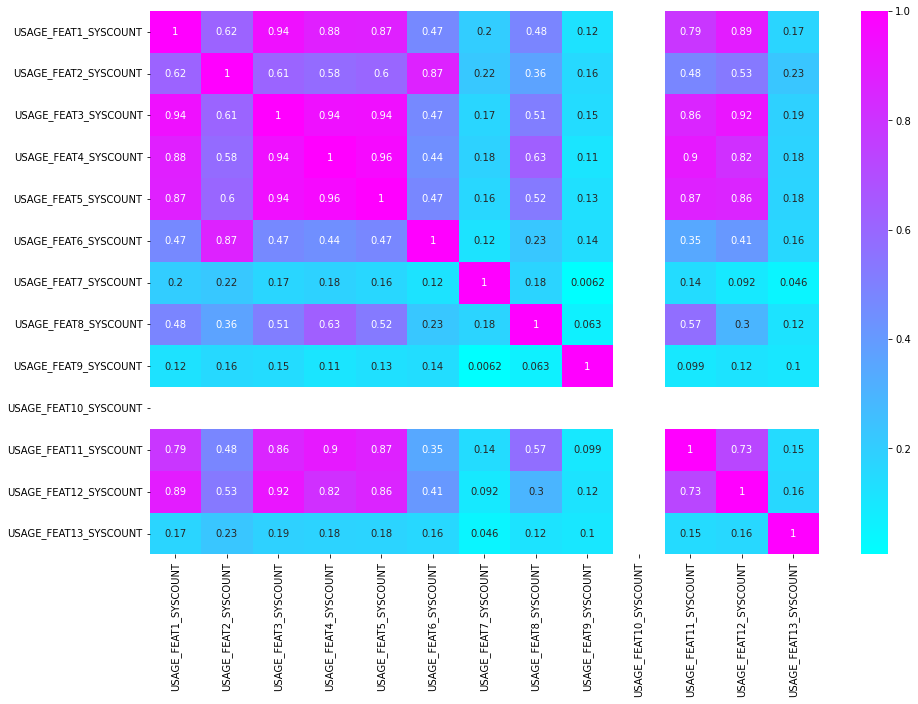

In [42]:
# correlation heat map for feat dataset

plt.figure(figsize=(15,10))
sns.heatmap(master_data[usage_feat_cols].corr(),cmap='cool',annot=True)
plt.show()

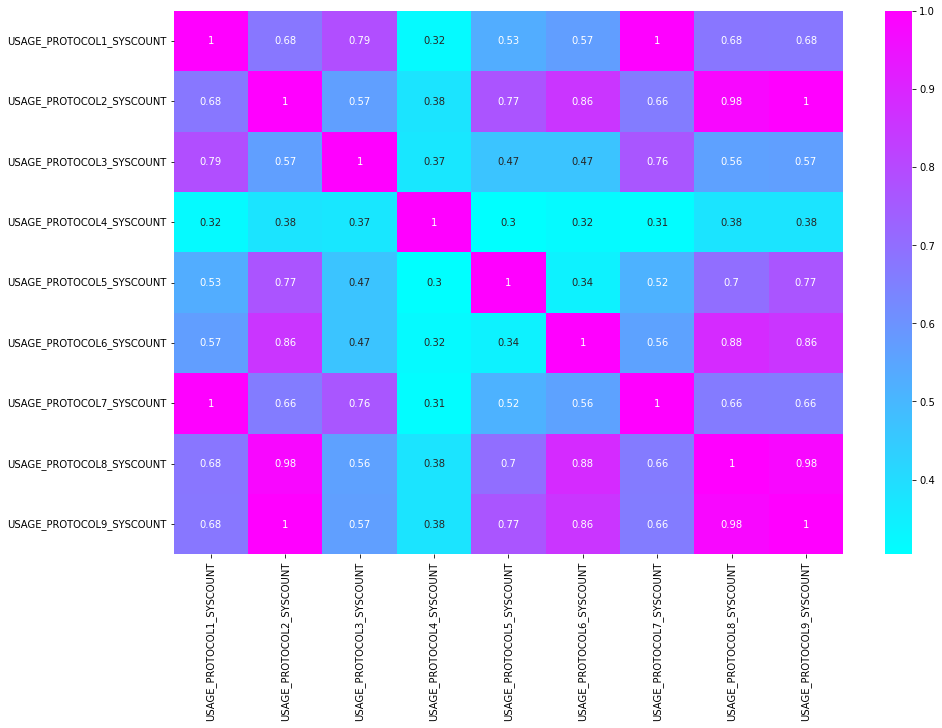

In [43]:
# correlation heat map for protocol dataset

plt.figure(figsize=(15,10))
sns.heatmap(master_data[usage_prtocol_cols].corr(),cmap='cool',annot=True)
plt.show()

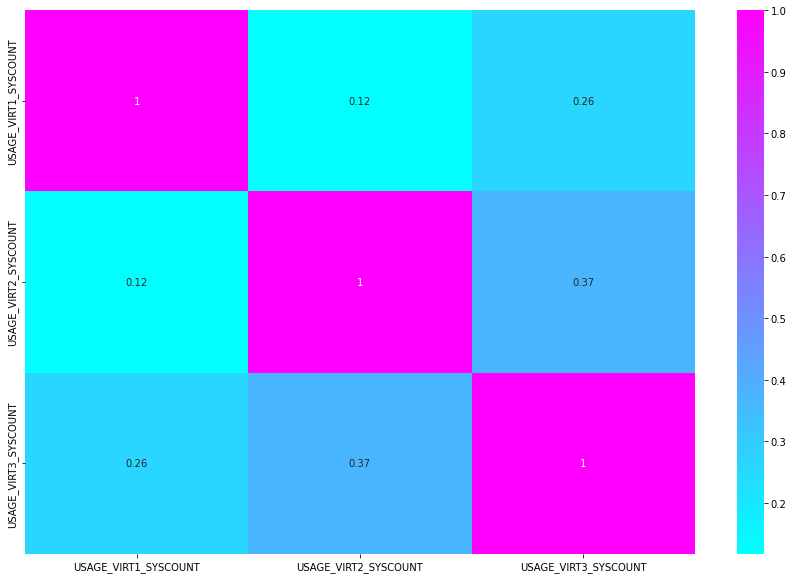

In [44]:
# correlation heat map for virt dataset

plt.figure(figsize=(15,10))
sns.heatmap(master_data[usage_virt_cols].corr(),cmap='cool',annot=True)
plt.show()

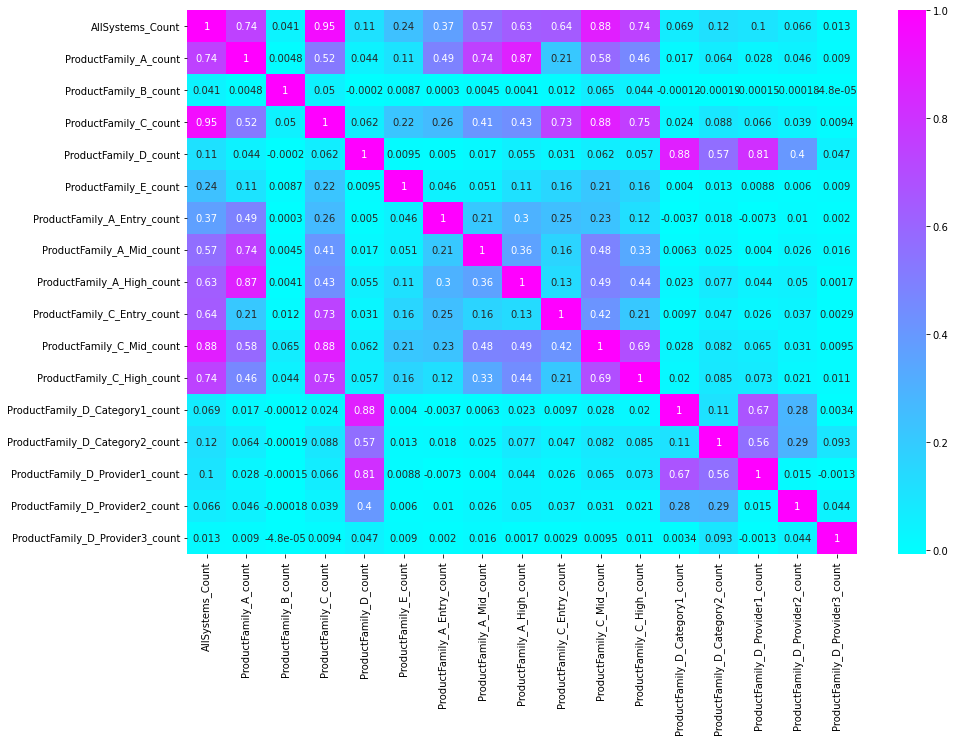

In [45]:
# correlation heat map for install count dataset

plt.figure(figsize=(15,10))
sns.heatmap(master_data[product_family_cols].corr(),cmap='cool',annot=True)
plt.show()

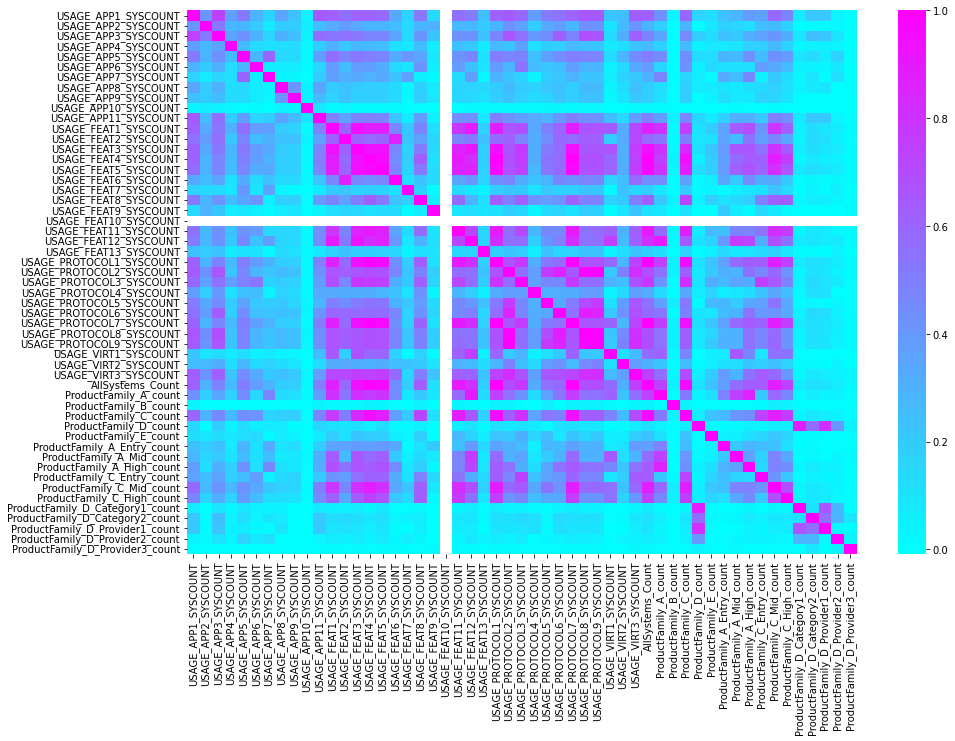

In [46]:
# correlation heat map for all columns

plt.figure(figsize=(15,10))
sns.heatmap(master_data[cols].corr(),cmap='cool')
plt.show()

#### Questions we need to answer about the data
1. Why are there outliers in each column? Before taking say 99% of the values, we should know what is causing the outliers
2. The coorelation graph shows significant correlation among variables. In order to understand the reason behind correlation, we need to know what each feature represents.

#### Understanding Firmographic Data

In [47]:
firmographic_data.describe()

,CompanyId,employees_total,revenue__total,total_budget_A,total_budget_A_A,total_budget_A_B,total_budget_A_C,total_budget_A_D,total_budget_A_A_A,total_budget_A_A_A_A,total_budget_A_A_A_B,total_budget_A_A_A_C,total_budget_A_A_A_D,total_budget_A_A_A_E,total_budget_A_C_A,total_budget_A_C_A_A,total_budget_A_C_A_B,total_budget_A_C_A_C,total_budget_A_C_A_D,total_budget_A_C_A_E
count,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03,4.829000e+03
mean,1.397450e+07,1.628295e+04,7.629900e+09,2.366683e+08,4.040480e+07,5.640051e+07,1.000684e+08,3.970526e+07,3.755032e+06,5.409205e+05,6.307632e+05,2.092921e+06,2.255398e+05,2.650319e+05,3.078918e+07,4.179891e+06,4.826958e+05,8.780010e+06,5.273853e+06,1.207666e+07
std,3.534766e+06,8.328163e+04,7.598716e+10,2.696969e+09,4.692118e+08,6.585725e+08,1.109527e+09,4.543303e+08,4.351528e+07,6.250387e+06,7.368798e+06,2.440204e+07,2.388707e+06,3.114225e+06,2.952502e+08,3.907949e+07,3.513512e+06,1.086821e+08,4.198079e+07,1.047477e+08
min,1.155606e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.163375e+07,3.030000e+02,1.016771e+08,8.758250e+05,1.483960e+05,2.004320e+05,3.790260e+05,1.462920e+05,1.270400e+04,1.769000e+03,2.229000e+03,7.082000e+03,6.600000e+02,9.200000e+02,1.141410e+05,1.538700e+04,1.465000e+03,2.724200e+04,1.541500e+04,5.092700e+04
50%,1.186623e+07,1.421000e+03,4.607921e+08,7.742759e+06,1.310840e+06,1.829346e+06,3.339179e+06,1.292481e+06,1.169670e+05,1.659100e+04,2.055300e+04,6.504100e+04,6.779000e+03,8.506000e+03,1.050824e+06,1.430680e+05,1.471900e+04,2.561270e+05,1.755590e+05,4.381800e+05
75%,1.738202e+07,7.000000e+03,2.512831e+09,5.828264e+07,9.776996e+06,1.367471e+07,2.516357e+07,9.780517e+06,9.011370e+05,1.284130e+05,1.548760e+05,4.967060e+05,5.514200e+04,6.675900e+04,8.165621e+06,1.094716e+06,1.202660e+05,1.985245e+06,1.361562e+06,3.229708e+06
max,2.188745e+07,2.800000e+06,4.790000e+12,1.700000e+11,2.958868e+10,4.159059e+10,6.973560e+10,2.864587e+10,2.741925e+09,3.939700e+08,4.646004e+08,1.538450e+09,1.485216e+08,1.963824e+08,1.812022e+10,2.389834e+09,1.909708e+08,6.870393e+09,2.328777e+09,6.340246e+09


<AxesSubplot:>

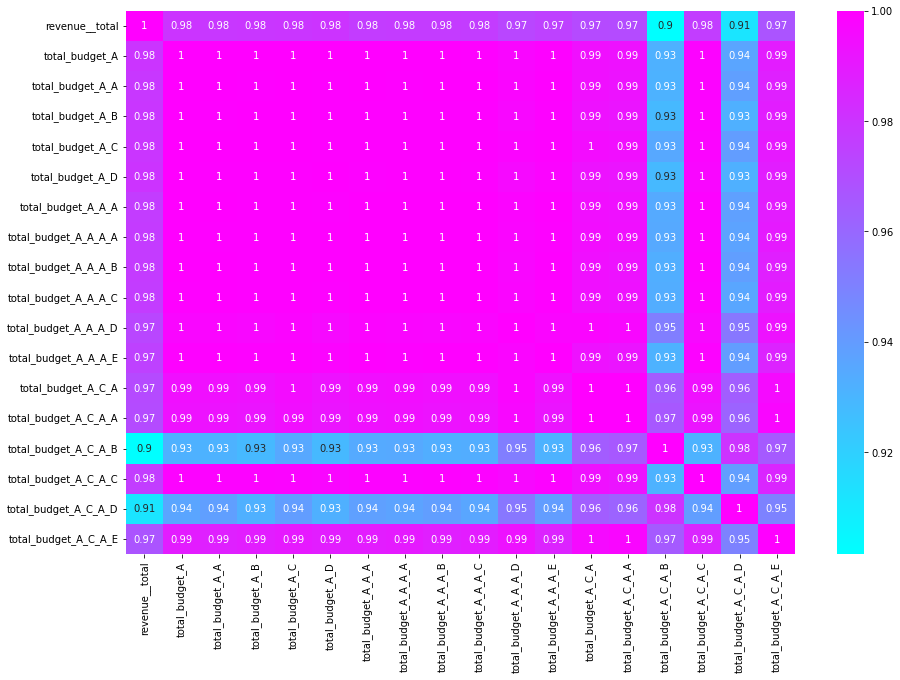

In [49]:
# correlation heat map for firmographic dataset

firmographic_cols = firmographic_data.columns[2:-2]

plt.figure(figsize=(15,10))
sns.heatmap(firmographic_data[firmographic_cols].corr(),cmap='cool',annot=True)

All the revenue columns have very high correlation with each other. What is the significance of these different kind of data?

(array([4.53e+03, 1.63e+02, 5.10e+01, 2.20e+01, 1.60e+01, 2.00e+01,
        8.00e+00, 5.00e+00, 4.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 1.00e+00]),
 array([      0.,   56000.,  112000.,  168000.,  224000.,  280000.,
         336000.,  392000.,  448000.,  504000.,  560000.,  616000.,
         672000.,  728000.,  784000.,  840000.,  896000.,  952000.,
        1008000., 1064000., 1120000., 1176000., 1232000., 1288000.,
        1344000., 1400000., 1456000., 1512000., 1568000., 1624000.,
        1680000., 1736000., 1792000., 1848000., 1904000., 1960000.,
        2016000., 

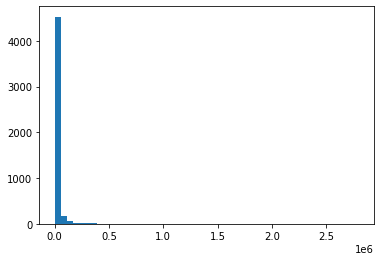

In [50]:
# total employee history plot

plt.hist(firmographic_data['employees_total'],bins=50)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

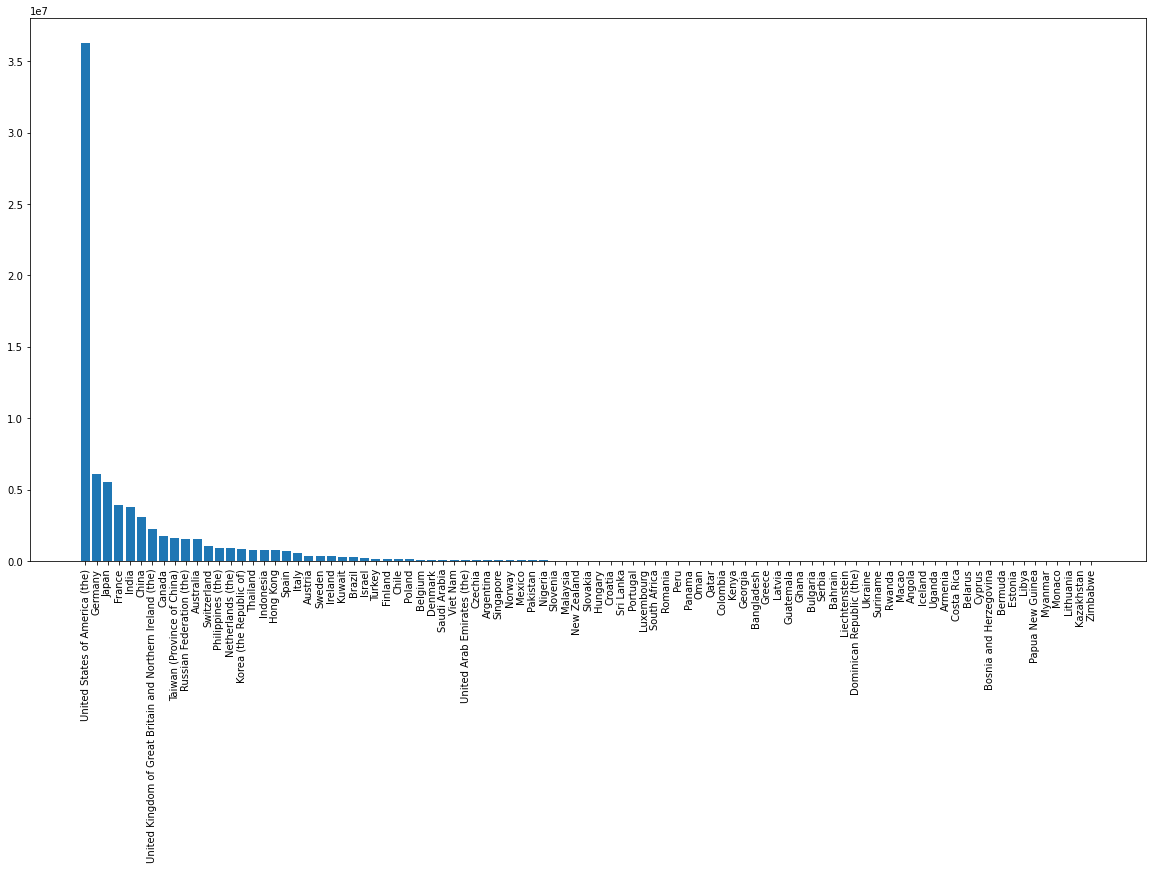

In [51]:
country_employees = firmographic_data.groupby(['country_name'])['employees_total'].sum().reset_index()
country_employees.sort_values('employees_total',ascending=False,inplace=True)
plt.figure(figsize=(20,10))
plt.bar(country_employees['country_name'],country_employees['employees_total'])
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

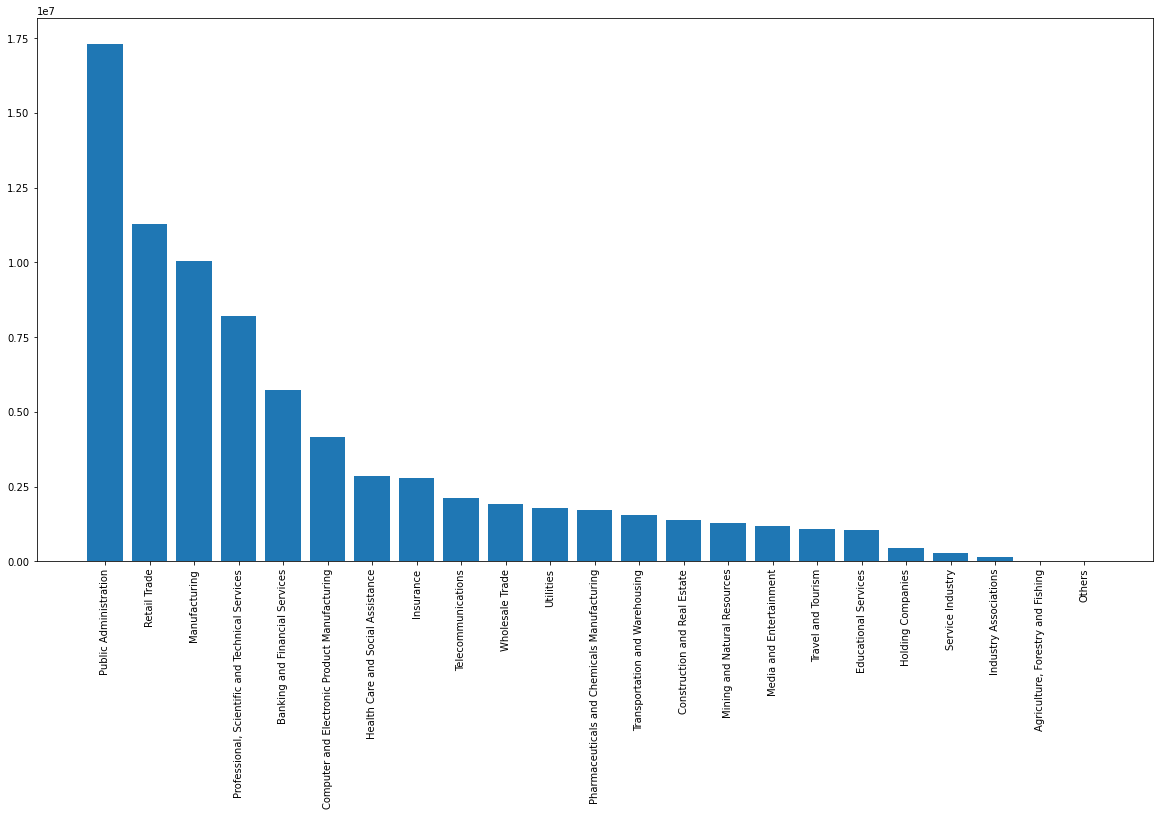

In [52]:
country_employees = firmographic_data.groupby(['industry_name'])['employees_total'].sum().reset_index()
country_employees.sort_values('employees_total',ascending=False,inplace=True)
plt.figure(figsize=(20,10))
plt.bar(country_employees['industry_name'],country_employees['employees_total'])
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

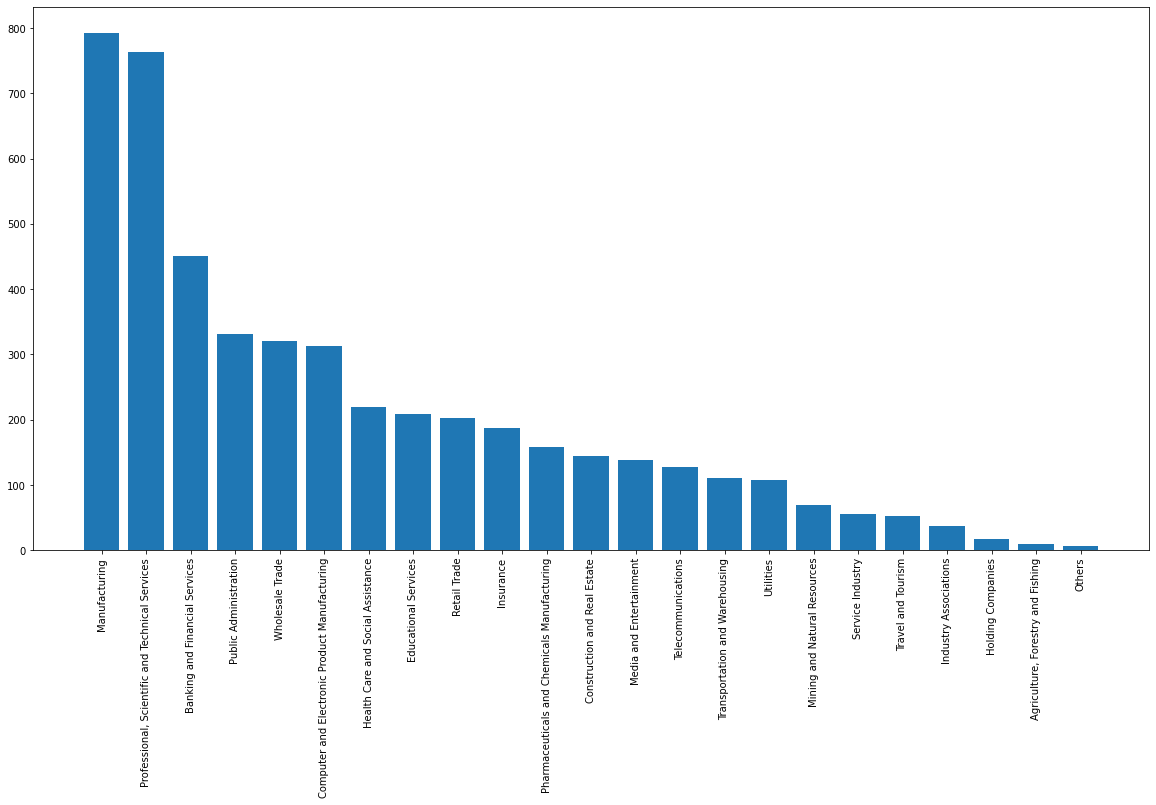

In [53]:
country_employees = firmographic_data.groupby(['industry_name'])['CompanyId'].nunique().reset_index()
country_employees.sort_values('CompanyId',ascending=False,inplace=True)
plt.figure(figsize=(20,10))
plt.bar(country_employees['industry_name'],country_employees['CompanyId'])
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

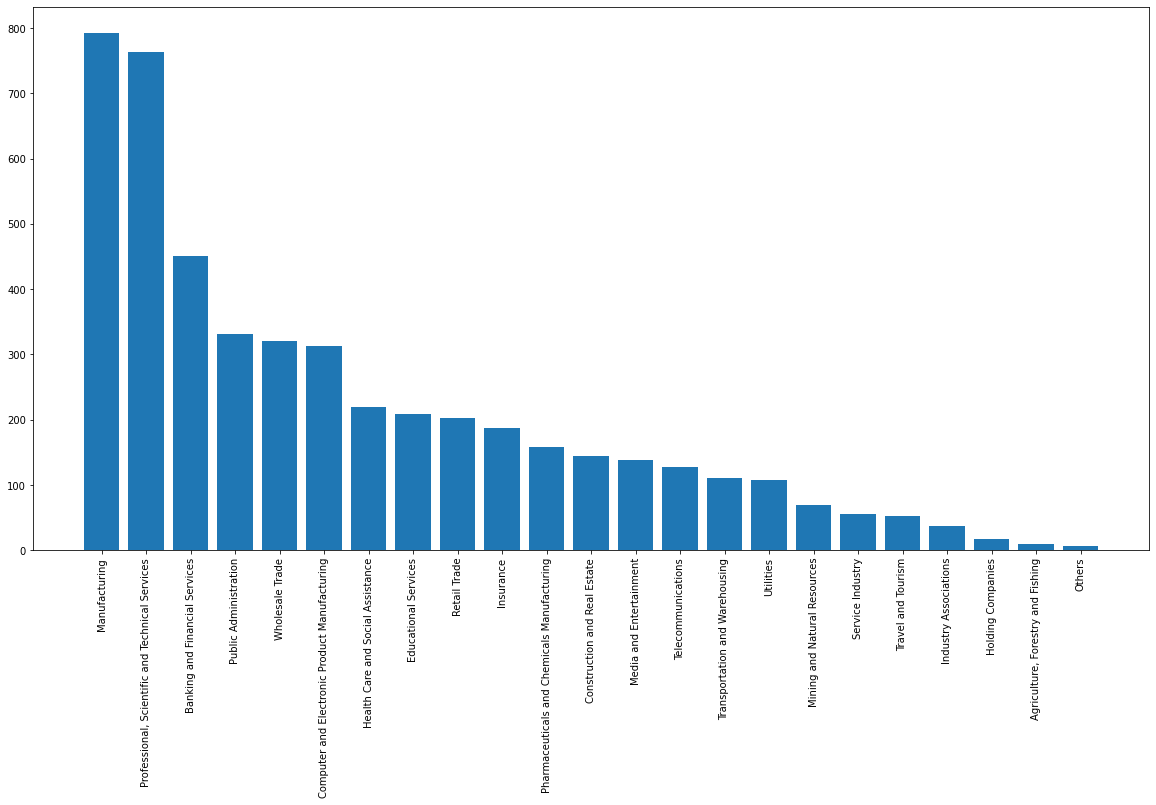

In [54]:
country_employees = firmographic_data.groupby(['industry_name'])['CompanyId'].count().reset_index()
country_employees.sort_values('CompanyId',ascending=False,inplace=True)
plt.figure(figsize=(20,10))
plt.bar(country_employees['industry_name'],country_employees['CompanyId'])
plt.xticks(rotation=90)

In [55]:
# remove 995 above outliers

outlier_dict = {}
for col in cols:
    outlier_dict[col] = np.percentile(master_data[col],99)
    
for col in cols:
    master_data = master_data[master_data[col]<=outlier_dict[col]]